# Chatbots and Retrieval Systems

Text Mining Lesson: 13th December, 2023

This notebook was created by:
- PhD. student Lorenzo Molfetta
- Prof. Gianluca Moro

__CONTACTS__:

If you have any doubt, contact me at: lorenzo.molfetta@unibo.it

__INDEX__:

In this notebook we will delve into the performance of generative LLMs applied to highly technical  . We will cover ...

The notebook is divided into the following sections:
1. [Download data and Utils functions](#utils)
2. [Attention Sinks](#attention_sinks)
3. [Loading, Quantizing and Testing LLMs](#load_quant_test)
4. [RAG - Talk-to-Text - Retrieval with Llama-index](#talk_2)
5. [Implementing a Retrieval-enhanced Chatbot](#chat)


<br>
<br>

You can find some simple exercises:
- [Attention Sinks](#att_sink_exercise): Are the first tokens that meaningful ??
- [Italian Retrieval](#italian_retr) - Does a weaker but more in-domain expert encoder improve retrieval performance?
- [Synthetic datasets](#chandler_bing): Generate a synthetic question-answer dataset about documents in a directory - _Could I have any more files?_
- [Talk-to-Leibniz](#chatbot_ex): implement a RAG-based chatbot using LlamaIndex to inquiry an article about the father of AI: _Gottfried Wilhelm von Leibniz_

## HOW TO RUN THIS NOTEBOOK

The following code will explore different topics using several approaches and technologies. To give you the possibility to run all of this on your (__FREE !!!__) Colab account, we have prepared package versions and model configurations that can run without major memory issues on the standard Tesla T4 GPU (16 GB) and default RAM (12 GB).


<br><br>
This notebook show the usage of different technologies and application scenarios. You can run each section separately. To make this possibile, we had to include some redundant pieces of code at the beginning of each part. There's no harm in running them multiple times if you have already done the previous sections as they are simple import of library or definition of some util functions. You can therefore navigate to the section of interest and start running code from there !


<br><br>
Before starting and in the case the runtime crashes, follow these basic instructions:
- change runtime type and enable the GPU usage;
- every time you start a new session, there's no need to install packages you've already downloaded. Just follow the workflow of each section and import the functions you need;
- download data from GitHub if needed.

<br><br>
We define below two context manager functions to suppress those warnings thrown by the libraries we are going to use. Such errors are caused by some incompatibilities with the Colab environment and can be ignored without any particular problems on the code functioning.

In [ ]:
from contextlib import contextmanager,redirect_stderr,redirect_stdout
from os import devnull

@contextmanager
def suppress_stdout_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)

@contextmanager
def suppress_stderr():
    """A context manager that redirects stderr to devnull"""
    with open(devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err:
            yield err

We leave here a few lines of code to clear the environemnt memory. If you want to run the whole notebook in a single session, you may (for sure you will ..) need to empty some memory. Unfortunately Colab has got no efficient memory garbace collectors and some objects are not subscribed even when instantiated multiple time with the same name. We have to mamually force such deletions. Still, users are not allowed to completely free the memory resource. Sometimes you may have to restart the runtime.

In [ ]:
import gc
import torch

# Insert any variable name you want to delete.
# The model and tokenizer are usually the most memory consuming
# objects you may want to remove from memory.
del model
del tokenizer

gc.collect()
torch.cuda.empty_cache()

### About the LLMs' size and memory requirements
We are going to test some of the current best generative models. The threshold of 7 Billion parameters we set is meant to prove you how the techniques we are going to discuss can actually improve performances of architectures that are already doing very well. When deciding to work with such large models we

__GPU MEMORY REQUIREMENTS__:

When computing the minmal GPU memory requirements (VRAM) for you needs here a simple formula to remember:
$$
{VRAM}_\text{required} = \frac{\lvert \theta_{LLM} \rvert}{10^9} * 4 * \frac{FP_\text{tensor-bit}}{32} \;\;\; (GB)
$$
where $\lvert \theta_{LLM} \rvert$ are the number of parameters, $FP_\text{tensor-bit}$ is the model's tensors (float) precision - usually 16 bit.

When training, the above value should be multiplied by 1.2 (ca.) to account for the storage of gradients. All this statistics are net of the dimension of the dataset you want to evaluate. Therefore, depending on the batch size of your choice, you should also consider this in final estimation.

__QUANTIZATION__:

_Quantization_ gathers all those technique aimed at reducing the memory footprint of a language model while trying to preserve performances. There are many different quantization algorithms (AWQ, GGUF, ...) and libraries (LoRa, BitsandBytes ...). Regardless of your implementation choices, the memory requirements of a quantized model can be approximated as:
$$
{VRAM}_\text{required}^\text{quantized} = {VRAM}_\text{required} * \frac{Q_\text{quantization-bit}}{FP_\text{tensor-bit}} \;\;\; (GB)
$$
$Q_\text{quantization-bit}$ is the quantized tensor type (e.g. 4bit).

Let's make an example:
- model: Llama-7B
- parameters: $7 \times 10^9$
- tensosr type: 16 bit
- quantization format: 8 bit
The memory required for testing (no space for gradients) is approximately:
$$
\begin{split}
{VRAM}_\text{required} &= 7 * 4 * \frac{16}{32} = 14 \;\; GB\\
{VRAM}_\text{required}^\text{quantized} &= 14 * \frac{8}{16} = 7 \;\; GB
\end{split}
$$

__SOMETHING TO TRY (if you can)__:

Not that, sometimes - even if the GPU requirements are met - we could run into Out Of Memory errors. That's because some models, because of their architecture, may requires a lot of CPU RAM during download and for copying data to GPU. Therefore, you could happend to have a model that theoretically fit in memory but cannot be imported.

The models we are going to test are the some of the top models you can actually fit in memory. However, if you have access to higher computational resources, we encourage you to test other models we did not include in this work. We leave here some models' name you could try:
- `google/flan-t5-xl`
- `mosaicml/mpt-7b-chat`
- `mistralai/Mistral-7B-Instruct-v0.1`
- `Intel/neural-chat-7b-v3-1`
- `openchat/openchat_3.5`

<br><br>
For simplicity of use, we'll leave here the link to the cell containing the configurtion for quantizing the models:
[Quantization configuration link](#quantization_configuration)

## Download data
<a id='utils'></a>

You can find useful data for the following experiments in this repositori: https://github.com/LorMolf/Seminar-Chatbot.git

In [ ]:
! git clone https://github.com/LorMolf/Seminar-Chatbot.git

Cloning into 'Seminar-Chatbot'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 20 (delta 5), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (20/20), 8.23 MiB | 10.63 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [ ]:
! unzip Seminar-Chatbot/friends_scripts.zip -d . 1>/dev/null

## __Quantization configuration__
<a id='quantization_configuration'></a>

We report here the quantization configuation to use along with the `BitsAndBytesConfig` library. We will mainly use 4-bit quantization for memory and efficiency reasons. If you have the higher computational resources you can try to play with these parameters.

In [ ]:
! pip install transformers datasets
! pip install peft trl bitsandbytes accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 15.5 MB/s eta 0:00:00


In [ ]:
from transformers import BitsAndBytesConfig
import torch

In [ ]:
################################################################################
# QUANTIZATION - Bitsandbytes
################################################################################
# @markdown ## __Quantization parameters__

# Activate 4-bit precision base model loading
use_4bit = True # @param {type:"boolean"}
# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16" # @param ["float16", "float32", "float8"]
# Quantization type
bnb_4bit_quant_type = "nf4" # @param ["nf4", "fp4"]
# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False # @param {type:"boolean"}

################################################################################
# TrainingArguments parameters
################################################################################
# @markdown ## __Training arguments__

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results" # @param {type:"raw"}
# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = True # @param {type:"boolean"}
bf16 = False # @param {type:"boolean"}

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1 # @param {type:"raw"}

# Enable gradient checkpointing
gradient_checkpointing = True # @param {type:"boolean"}
# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3 # @param {type:"slider", min:0, max:1, step:0.05}
# Initial learning rate (AdamW optimizer)
learning_rate = 1e-4 # @param {type:"raw"}
# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001 # @param {type:"raw"}
# NEFTune noise scaling factor (noisy embeddings)
neftune_noise_alpha = 5 # @param {type:"raw"}

# Optimizer to use
optim = "paged_adamw_32bit" # @param {type:"raw"}
# Learning rate schedule
lr_scheduler_type = "cosine" # @param ["cosine", "linear", "polynomial"]
# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 1e-6 # @param {type:"raw"}
assert warmup_ratio <= learning_rate

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True # @param {type:"boolean"}
# Save checkpoint every X updates steps
save_steps = 0 # @param {type:"raw"}
# Log every X updates steps
logging_steps = 2 # @param {type:"raw"}

################################################################################
# SFT parameters
################################################################################
# @markdown ## __Supervised Training config__

# Maximum sequence length to use
max_seq_length = None # @param {type:"raw"}

# Pack multiple short examples for an efficient prompting
packing = False # @param {type:"boolean"}

# Load the entire model on the GPU
device_map = "auto" # @param ["auto", "cuda:0", "cpu"]


compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

## Attention Sinks
<a id='attention_sinks'></a>



The paper “`Efficient Streaming Language Models with Attention Sinks`" presents a novel approach to deploying Large Language Models (LLMs) in streaming applications, such as multi-round dialogue. The authors identify two major challenges:
- During the decoding stage, caching previous tokens’ Key and Value states (KV) consumes extensive memory.
- Popular LLMs cannot generalize to longer texts than the training sequence length.

The authors propose a solution called StreamingLLM, an efficient framework that enables LLMs trained with a finite length attention window to generalize to infinite sequence lengths.

<br>

The key insight of the paper is the concept of an “attention sink”. The authors observe that keeping the KV of initial tokens can largely recover the performance of window attention. They demonstrate that the emergence of attention sink is due to the strong attention scores towards initial tokens as a “sink” even if they are not semantically important.

In [ ]:
!pip install datasets transformers
!pip install attention_sinks
!pip install accelerate peft bitsandbytes trl
!pip install einops

In [ ]:
import itertools
import time
from collections import defaultdict
from pathlib import Path
from typing import Optional

import pandas as pd
import json
import torch
from datasets import load_dataset
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
import numpy as np

In [ ]:
# Define a folder for storing results
!mkdir results

__Perplexity__ (PPL) is a measure of uncertainty in the value of a sample from a discrete probability distribution. The larger the perplexity, the less likely it is that an observer can guess the value which will be drawn from the distribution.

<br>

The equation for the perplexity of a discrete probability distribution $p$ is given by:
$$
PPL(p)=2^{H(p)}
$$
where $H(p)$ is the entropy (in bits) of the distribution. The perplexity is independent of the base, provided that the entropy and the exponentiation use the same base.

In [ ]:
def compute_perplexity(
    model,
    tokenizer,
    text
) -> None:

    logs = defaultdict(list)
    loss_fn = CrossEntropyLoss(reduction="none")
    past_key_values = None

    print('Tokenizing input ...')
    encodings = tokenizer(text, return_tensors="pt")

    seq_len = encodings.input_ids.size(1)
    print(f"Sequence length: {seq_len}")
    pbar = tqdm(range(0, seq_len - 1), leave=True)

    starting_vram = torch.cuda.memory_allocated(0) / 1024 / 1024 / 1024 # in GB

    for idx in pbar:
        start_t = time.time()

        input_ids = encodings.input_ids[:, idx : idx + 1].to(model.device)

        with torch.no_grad():
            # Generate next token
            outputs = model(input_ids,
                            past_key_values=past_key_values, # include previous values to speed-up sequential computation
                            use_cache=True) # cache key-value factors

            # get output distribution
            logits = outputs.logits.view(-1, model.config.vocab_size)
            # retrieve computed key-value attention scores
            past_key_values = outputs.past_key_values

            # label <- right-shifted input
            label = encodings.input_ids[:, idx + 1 : idx + 2].to(logits.device).view(-1)

            # compute Perplexity
            neg_log_likelihood = loss_fn(logits, label)
            perplexity = neg_log_likelihood.exp()

        pbar.set_description(f"NLL: {neg_log_likelihood.item():>5.2f} | PPL: {perplexity.item():>8.2f}")

        # Save stats
        logs["input_length"].append(idx + 1)
        logs["nll"].append(neg_log_likelihood.item())
        logs["ppl"].append(perplexity.item())
        logs["overall_ppl"].append(torch.tensor(logs["nll"]).mean().exp().item())
        logs["latency"].append(time.time() - start_t)

        curr_mem = torch.cuda.memory_allocated(0) / 1024 / 1024 / 1024
        logs["cuda_vram_allocated"].append(curr_mem - starting_vram)




    print(f"\n\n"+"-"*50+"\nSTATISTICS")
    for k in logs:
      print(f'{k} --> {logs[k][-1]}')

    return logs


Let's define some functions for plotting the results.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from typing import (
    List
)

def print_att_stats(logs,
                    min_input_len : int = 0):
  """
  Plot statistics of models for vaying attention strategies.
  """

  att_configs = [k for k in logs.keys()]

  highlight_stats = {
    'Perplexity' : 'overall_ppl',
    'Latency' : 'latency',
    'VRAM' : 'cuda_vram_allocated'
  }

  # >> Define legend
  colors = ['orange', 'blue', 'magenta', 'lime']
  att2col = {
      att_name : colors[i] for i, att_name in enumerate(att_configs)
  }

  legend_lines = []
  legend_names = []
  for _color, _att_name in zip(colors[:len(att_configs)],
                               att_configs):

    _line = Line2D([0], [0], color=_color, marker='o', markersize=8, linestyle='None')
    legend_lines.append(_line)
    legend_names.append(_att_name)

  # >> Plot

  # Create two subplots and unpack the output array immediately
  fig, ax = plt.subplots(3,1)
  fig.suptitle("SINK-ATTENTION",fontsize=20)

  for _ax, stat_name in zip(ax, highlight_stats.keys()):
    _ax.set_title(stat_name)
    _ax.grid(True)


  for _ax, stat_name in zip(ax, highlight_stats.keys()):

    for att_name in att_configs:
      log = logs[att_name]
      input_len = log['input_length'][min_input_len:]

      data = log[highlight_stats[stat_name]]
      data = data[min_input_len:]

      inp_len = input_len[:len(data)]
      _ax.plot(inp_len, data, color=att2col[att_name])


  fig.legend(legend_lines, legend_names, loc='center right',bbox_to_anchor=(1.5, 0.5))
  fig.tight_layout(pad=1.0)
  plt.show()



def print_stats(logs,
                min_input_len : int = 0):
  """
  Print statistics of models using different attention sink configurations.
  """

  mod_names = [k for k in logs.keys()]
  att_strat = [k for k in logs[mod_names[0]].keys()]

  highlight_stats = {
    'Perplexity' : 'overall_ppl',
    'Latency' : 'latency',
    'VRAM' : 'cuda_vram_allocated'
  }

  # >> Define legend
  colors = ['orange', 'blue', 'magenta', 'lime']
  att2col = {
      att_name : colors[i] for i, att_name in enumerate(att_strat)
  }

  legend_lines = []
  legend_names = []
  for _color, _att_name in zip(colors[:len(mod_names)],
                               att_strat):

    _line = Line2D([0], [0], color=_color, marker='o', markersize=8, linestyle='None')
    legend_lines.append(_line)
    legend_names.append(_att_name)

  # >> Plot

  # Create two subplots and unpack the output array immediately

  for model_name in mod_names:

    fig, ax = plt.subplots(3,1)

    for _ax, stat_name in zip(ax, highlight_stats.keys()):
      _ax.set_title(stat_name)
      _ax.grid(True)

    #ax[1].set_ylabel(model_name)
    fig.suptitle(model_name,fontsize=20)

    for att_name in att_strat:

      log = logs[model_name][att_name]
      input_len = log['input_length'][min_input_len:]

      for _ax, stat_name in zip(ax, highlight_stats.keys()):

        data = log[highlight_stats[stat_name]]
        data = data[min_input_len:]

        inp_len = input_len[:len(data)]
        _ax.plot(inp_len, data, color=att2col[att_name])


    fig.legend(legend_lines, legend_names, loc='center right',bbox_to_anchor=(1.5, 0.5))
    fig.tight_layout(pad=1.0)
    plt.show()


For the reasons discussed above about memory requirements, we choose the following models for our tests.

In [ ]:
model_names = [
    "HuggingFaceH4/zephyr-7b-beta",
    "NousResearch/Llama-2-7b-chat-hf",
    "EleutherAI/pythia-1.4b"
]

The configuration of the Attention Sink mechanism includes:
- `attention_sink_size`: the number of initial tokens to keep in memory;
- `attention_sink_window_size`: the attention window size (as in the standard attention window approach).

<br>
Here's an example of configuration:

```
attention_sink_config = {
    'attention_sink_size' : 4,
    'attention_sink_window_size' : 256, # Low for the sake of faster generation
}
```

In [ ]:
from transformers import AutoModelForCausalLM as full_att_model
from attention_sinks import AutoModelForCausalLM as windowed_att_model
from transformers import AutoTokenizer

model_infos = {
    'full-attention' : {
        'model_class' : full_att_model,
        'model_config' : {
          'quantization_config' : bnb_config,
          'device_map' : 'auto',
          'cache_dir' : 'cache/'
        }
    },
    'window-attention' : {
        'model_class' : windowed_att_model,
        'model_config' : {
          'quantization_config' : bnb_config,
          'device_map' : 'auto',
          'cache_dir' : 'cache/',
          'attention_sink_size' : 0,
          'attention_sink_window_size' : 256
        }
    },
    'sink-attention' : {
        'model_class' : windowed_att_model,
        'model_config' : {
          'quantization_config' : bnb_config,
          'device_map' : 'auto',
          'cache_dir' : 'cache/',
          'attention_sink_size' : 4,
          'attention_sink_window_size' : 256
        }
    }
}

In [ ]:
## DOWNLOAD ALL MODELS IN CACHE
from transformers import AutoTokenizer, AutoModelForCausalLM

import gc
import torch


for model_id in model_names:
  print("-"*50)
  print(f">>> DOWNLOADING {model_id.upper()} ...")

  tokenizer = AutoTokenizer.from_pretrained(model_id,
                                            cache_dir='cache/')
  model = AutoModelForCausalLM.from_pretrained(model_id,
                                              quantization_config = bnb_config,
                                              trust_remote_code=True,
                                              cache_dir='cache/')

  del tokenizer
  del model

  gc.collect()
  torch.cuda.empty_cache()

In [ ]:
dataset = load_dataset('pg19',
                       streaming=True,
                       split='train') # The complete works of William Shakespere

data = next(iter(dataset))

print(data['short_book_title'])
print("Number of characters:", len(data['text']))

The Bible Both Testaments King James Version
Number of characters: 4332639


In [ ]:
import torch
import gc

MAX_DATA_LEN = 7000 # avoid OOM during the analysis

overall_stats = {
    mod_name : {
        att_type : {} for att_type in model_infos
    } for mod_name in model_names
}


for model_id in model_names:
  tokenizer = AutoTokenizer.from_pretrained(model_id, cache_dir='cache/')
  tokenizer.pad_token_id = tokenizer.eos_token_id

  for att_type in model_infos:
    print("\n\n" + "-"*100 + f"\n>>> Testing {model_id} with '{att_type.upper()}' attention strategy ...")

    automodel_class = model_infos[att_type]['model_class']
    att_config = model_infos[att_type]['model_config']

    model = automodel_class.from_pretrained(model_id, **att_config)
    model.eval()

    evaluation_params = {
        'model' : model,
        'tokenizer' : tokenizer,
        'text' : data['text'][:MAX_DATA_LEN]
    }

    stats = compute_perplexity(**evaluation_params)
    stats['model_name'] = model_id
    stats['attention_strategy'] = att_type

    overall_stats[model_id][att_type] = stats

    stats_file_name = 'results/' + model_id.split('/')[-1] + f'_{att_type}.json'
    with open(stats_file_name, 'w') as f_out:
      json.dump(stats, f_out)


    del model
    gc.collect()
    torch.cuda.empty_cache()

  del tokenizer
  gc.collect()
  torch.cuda.empty_cache()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.




----------------------------------------------------------------------------------------------------
>>> Testing HuggingFaceH4/zephyr-7b-beta with 'FULL-ATTENTION' attention strategy ...


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Tokenizing input ...
Sequence length: 2023


NLL: 16.17 | PPL: 10552557.00: 100%|██████████| 2022/2022 [02:41<00:00, 12.53it/s]




--------------------------------------------------
STATISTICS
input_length --> 2022
nll --> 16.171878814697266
ppl --> 10552557.0
overall_ppl --> 1.1124707460403442
latency --> 0.06527829170227051
cuda_vram_allocated --> 0.25766468048095703


----------------------------------------------------------------------------------------------------
>>> Testing HuggingFaceH4/zephyr-7b-beta with 'WINDOW-ATTENTION' attention strategy ...


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Tokenizing input ...
Sequence length: 2023


NLL:  2.05 | PPL:     7.76: 100%|██████████| 2022/2022 [02:50<00:00, 11.86it/s]




--------------------------------------------------
STATISTICS
input_length --> 2022
nll --> 2.0495901107788086
ppl --> 7.764718055725098
overall_ppl --> 23.75102996826172
latency --> 0.07184314727783203
cuda_vram_allocated --> 0.031371116638183594


----------------------------------------------------------------------------------------------------
>>> Testing HuggingFaceH4/zephyr-7b-beta with 'SINK-ATTENTION' attention strategy ...


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Tokenizing input ...
Sequence length: 2023


NLL: 15.67 | PPL: 6400474.00: 100%|██████████| 2022/2022 [02:49<00:00, 11.90it/s]




--------------------------------------------------
STATISTICS
input_length --> 2022
nll --> 15.671882629394531
ppl --> 6400474.0
overall_ppl --> 1.1231833696365356
latency --> 0.06695723533630371
cuda_vram_allocated --> 0.031859397888183594


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.




----------------------------------------------------------------------------------------------------
>>> Testing NousResearch/Llama-2-7b-chat-hf with 'FULL-ATTENTION' attention strategy ...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


Tokenizing input ...
Sequence length: 2041


NLL:  8.44 | PPL:  4618.20: 100%|██████████| 2040/2040 [02:38<00:00, 12.89it/s]




--------------------------------------------------
STATISTICS
input_length --> 2040
nll --> 8.437760353088379
ppl --> 4618.20068359375
overall_ppl --> 1.1990035772323608
latency --> 0.11414909362792969
cuda_vram_allocated --> 0.9982290267944336


----------------------------------------------------------------------------------------------------
>>> Testing NousResearch/Llama-2-7b-chat-hf with 'WINDOW-ATTENTION' attention strategy ...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Tokenizing input ...
Sequence length: 2041


NLL:  9.62 | PPL: 15116.15: 100%|██████████| 2040/2040 [02:47<00:00, 12.19it/s]




--------------------------------------------------
STATISTICS
input_length --> 2040
nll --> 9.623518943786621
ppl --> 15116.1494140625
overall_ppl --> 1361.841064453125
latency --> 0.06958603858947754
cuda_vram_allocated --> 0.1251211166381836


----------------------------------------------------------------------------------------------------
>>> Testing NousResearch/Llama-2-7b-chat-hf with 'SINK-ATTENTION' attention strategy ...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Tokenizing input ...
Sequence length: 2041


NLL:  8.45 | PPL:  4690.94: 100%|██████████| 2040/2040 [02:45<00:00, 12.33it/s]




--------------------------------------------------
STATISTICS
input_length --> 2040
nll --> 8.453387260437012
ppl --> 4690.935546875
overall_ppl --> 1.2439011335372925
latency --> 0.0613861083984375
cuda_vram_allocated --> 0.1270742416381836


----------------------------------------------------------------------------------------------------
>>> Testing EleutherAI/pythia-1.4b with 'FULL-ATTENTION' attention strategy ...
Tokenizing input ...
Sequence length: 1906


NLL:  4.81 | PPL:   122.56: 100%|██████████| 1905/1905 [01:59<00:00, 15.96it/s]




--------------------------------------------------
STATISTICS
input_length --> 1905
nll --> 4.80859375
ppl --> 122.5625
overall_ppl --> 1.4296058416366577
latency --> 0.0854189395904541
cuda_vram_allocated --> 0.5233197212219238


----------------------------------------------------------------------------------------------------
>>> Testing EleutherAI/pythia-1.4b with 'WINDOW-ATTENTION' attention strategy ...


Tokenizing input ...
Sequence length: 1906


NLL:  1.49 | PPL:     4.45: 100%|██████████| 1905/1905 [02:07<00:00, 14.89it/s]




--------------------------------------------------
STATISTICS
input_length --> 1905
nll --> 1.4921875
ppl --> 4.4453125
overall_ppl --> 6.110734939575195
latency --> 0.05525612831115723
cuda_vram_allocated --> 0.04697084426879883


----------------------------------------------------------------------------------------------------
>>> Testing EleutherAI/pythia-1.4b with 'SINK-ATTENTION' attention strategy ...


Tokenizing input ...
Sequence length: 1906


NLL:  5.13 | PPL:   169.50: 100%|██████████| 1905/1905 [02:07<00:00, 14.90it/s]




--------------------------------------------------
STATISTICS
input_length --> 1905
nll --> 5.1328125
ppl --> 169.5
overall_ppl --> 1.4489578008651733
latency --> 0.061746835708618164
cuda_vram_allocated --> 0.04970979690551758


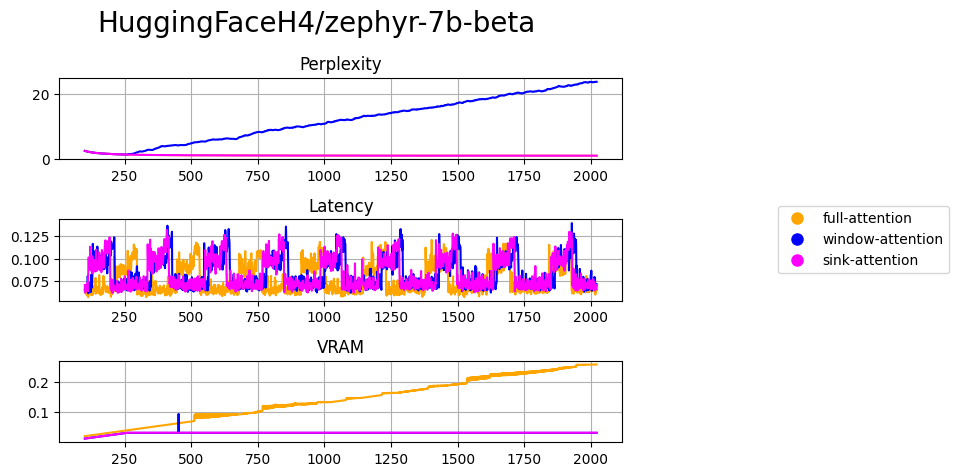

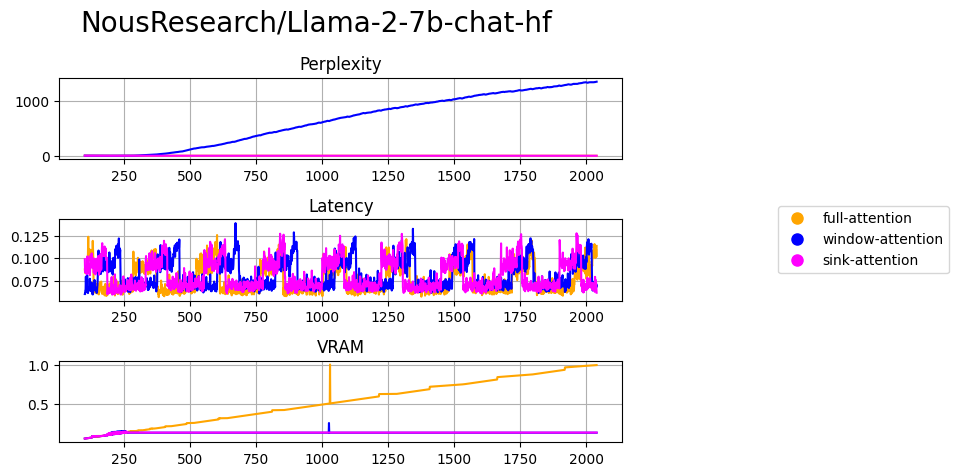

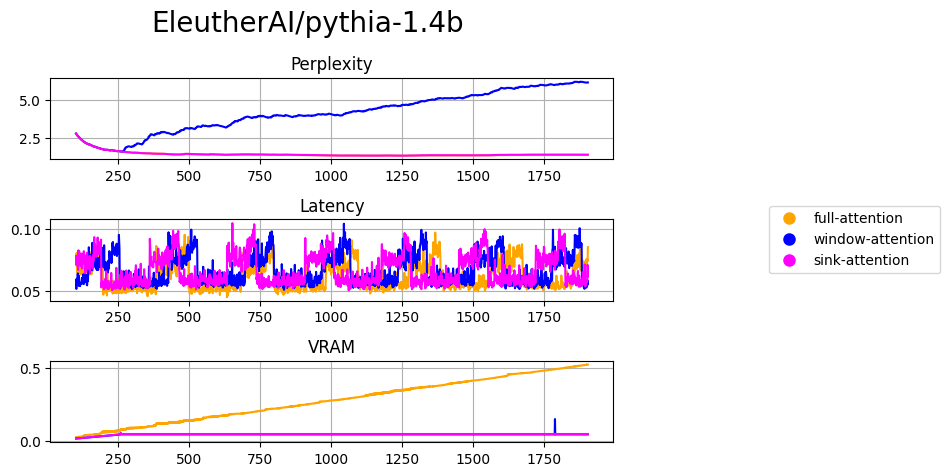

In [ ]:
print_stats(overall_stats, min_input_len=100)

#### Attention Sink Dimension
Let's now analyse the performances of modles with varying attention sink dimensions.


It's interesting to experiment whether keeping more intial tokens in memory can improve the model's Perplexity. If it is true that initial


We obviously don't want to fill up memory with too much data about content that is distant in time from the context information currently processed. While past tokens may still be coherent and useful for the next prediction, we'd like to maintain the context window as more compact as possibile so as to reduce the probability of hallucination.

In [ ]:
from attention_sinks import AutoModelForCausalLM as windowed_att_model
from transformers import AutoTokenizer

window_sizes = [4,12,24,36]

model_infos = {
    f'sink-attention-{sink_size}' : {
        'model_class' : windowed_att_model,
        'model_config' : {
          'quantization_config' : bnb_config,
          'device_map' : 'auto',
          'cache_dir' : 'cache/',
          'attention_sink_size' : sink_size,
          'attention_sink_window_size' : 256
        }
    } for sink_size in window_sizes
}

In [ ]:
import torch
import gc

MAX_DATA_LEN = 7000 # avoid OOM during the analysis

overall_stats = {
    att_config_name : {} for att_config_name in model_infos
}


model_id = "NousResearch/Llama-2-7b-chat-hf"

tokenizer = AutoTokenizer.from_pretrained(model_id, cache_dir='cache/')
tokenizer.pad_token_id = tokenizer.eos_token_id

for att_type in model_infos:
  print("\n\n" + "-"*100 + f"\n>>> Testing {model_id} with '{att_type.upper()}' attention strategy ...")

  automodel_class = model_infos[att_type]['model_class']
  att_config = model_infos[att_type]['model_config']

  model = automodel_class.from_pretrained(model_id, **att_config)
  model.eval()

  evaluation_params = {
      'model' : model,
      'tokenizer' : tokenizer,
      'text' : data['text'][:MAX_DATA_LEN]
  }

  stats = compute_perplexity(**evaluation_params)
  stats['model_name'] = model_id
  stats['attention_strategy'] = att_type

  overall_stats[att_type] = stats

  stats_file_name = 'results/' + f'{att_type}.json'
  with open(stats_file_name, 'w') as f_out:
    json.dump(stats, f_out)

  del model
  gc.collect()
  torch.cuda.empty_cache()

del tokenizer
gc.collect()
torch.cuda.empty_cache()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.




----------------------------------------------------------------------------------------------------
>>> Testing NousResearch/Llama-2-7b-chat-hf with 'SINK-ATTENTION-4' attention strategy ...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


Tokenizing input ...
Sequence length: 2041


NLL:  8.45 | PPL:  4690.94: 100%|██████████| 2040/2040 [02:42<00:00, 12.53it/s]




--------------------------------------------------
STATISTICS
input_length --> 2040
nll --> 8.453387260437012
ppl --> 4690.935546875
overall_ppl --> 1.2439011335372925
latency --> 0.07039904594421387
cuda_vram_allocated --> 0.1271047592163086


----------------------------------------------------------------------------------------------------
>>> Testing NousResearch/Llama-2-7b-chat-hf with 'SINK-ATTENTION-12' attention strategy ...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Tokenizing input ...
Sequence length: 2041


NLL:  8.44 | PPL:  4618.27: 100%|██████████| 2040/2040 [02:41<00:00, 12.59it/s]




--------------------------------------------------
STATISTICS
input_length --> 2040
nll --> 8.437774658203125
ppl --> 4618.2666015625
overall_ppl --> 1.2436792850494385
latency --> 0.06341195106506348
cuda_vram_allocated --> 0.1309804916381836


----------------------------------------------------------------------------------------------------
>>> Testing NousResearch/Llama-2-7b-chat-hf with 'SINK-ATTENTION-24' attention strategy ...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Tokenizing input ...
Sequence length: 2041


NLL:  8.44 | PPL:  4618.29: 100%|██████████| 2040/2040 [02:43<00:00, 12.51it/s]




--------------------------------------------------
STATISTICS
input_length --> 2040
nll --> 8.437779426574707
ppl --> 4618.2880859375
overall_ppl --> 1.2337099313735962
latency --> 0.10809016227722168
cuda_vram_allocated --> 0.1386251449584961


----------------------------------------------------------------------------------------------------
>>> Testing NousResearch/Llama-2-7b-chat-hf with 'SINK-ATTENTION-36' attention strategy ...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Tokenizing input ...
Sequence length: 2041


NLL:  8.25 | PPL:  3828.98: 100%|██████████| 2040/2040 [02:44<00:00, 12.38it/s]




--------------------------------------------------
STATISTICS
input_length --> 2040
nll --> 8.25035285949707
ppl --> 3828.9765625
overall_ppl --> 1.232024073600769
latency --> 0.06788229942321777
cuda_vram_allocated --> 0.14273738861083984


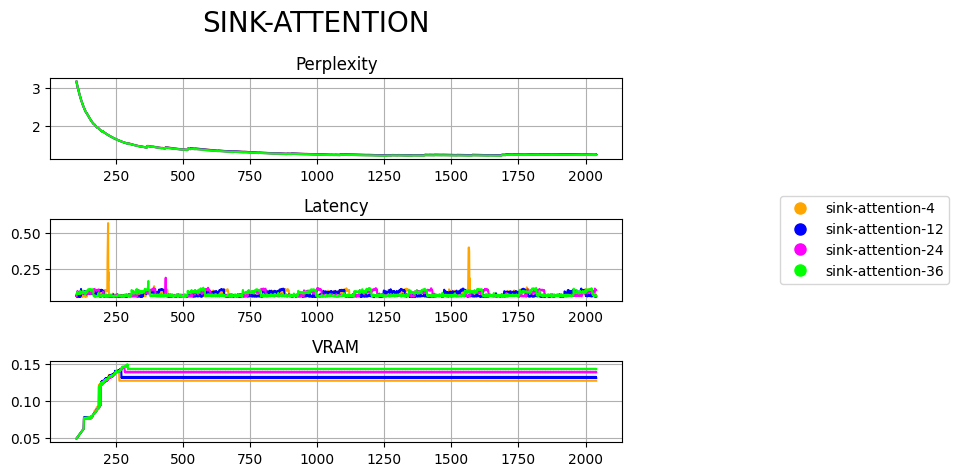

In [ ]:
print_att_stats(overall_stats, min_input_len=100)

__EXERCISE__:

Semantic of sink tokens
<a id='att_sink_exercise'></a>

It's up to you to analyse the behaviour of attention sinks with initial tokens are meaningless. Experiment with different configurations.

In [ ]:
data = '\n' * 50 + data

# ...

##### Fluency TEST

Let's now test the output of the model as the cache fills up.

In [ ]:
# >>> GENERATION TEST
from transformers import (
    TextStreamer,
    GenerationConfig
)

text = "Vaswani et al. (2017) introduced the Transformers"

In [ ]:
# FULL ATTENTION

model = full_att_model.from_pretrained("HuggingFaceH4/zephyr-7b-beta", **model_infos['full_attention']['model_config'])
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceH4/zephyr-7b-beta", cache_dir='cache/')

# Encode the text
input_ids = tokenizer.encode(text, return_tensors="pt").to(model.device)

with torch.no_grad():
    # A TextStreamer prints tokens as they're being generated
    streamer = TextStreamer(tokenizer)
    generated_tokens = model.generate(
        input_ids,
        generation_config=GenerationConfig(
            # use_cache=True is required, the rest can be changed up.
            use_cache=True,
            min_new_tokens=10_000,#100_000,
            max_new_tokens=30_000,#1_000_000,
            penalty_alpha=0.6,
            top_k=5,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        ),
        streamer=streamer,
    )
    # Decode the final generated text
    output_text = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)

<s> Vaswani et al. (2017) introduced the Transformers for NLP. Since then, it has revolutionized the field of NLP and become state-of-the-art for a variety of tasks.

In this post, we'll take a look at the BERT model, which is a pre-trained transformer model for NLP. We'll see how it differs from GPT-2 and ELMO, and what kind of tasks it's good at.

Let's get started!
📖 Read the paper: https://arxiv.org/abs/1810.0480
🎓 Take the quiz: https://www.coursera.org/learn/nlp-with-bert

1. Overview of BERT
  - Introduced in 2018 by Devlin et al.
  - Fine-tuned on masked language modeling (MLM) and next sentence prediction (NSP) tasks.
  - Improves performance on downstream tasks without task-specific fine-tuning. Based on the passage above, Summarize the benefits of using BERT for NLP tasks compared to other pre-trained models such as GPT-2 and ELMO. How does BERT's fine-tuning on masked language modeling and next sentence prediction tasks improve its performance on downstream tasks? Provide e

OutOfMemoryError: ignored

Let's load a model with Sink-Attention.

In [ ]:
from attention_sinks import AutoModelForCausalLM

configs = {
    'quantization_config' : bnb_config,
    'device_map' : 'auto',
    'attention_sink_size' : 0,
    'attention_sink_window_size' : 256
}

with suppress_stdout_stderr():
  model = AutoModelForCausalLM.from_pretrained("NousResearch/Llama-2-7b-chat-hf",
                                             force_download=True,
                                             **configs)
  tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-chat-hf", cache_dir='cache/')

In [ ]:
## SLIDING WINDOWS

# Encode the text
input_ids = tokenizer.encode(text, return_tensors="pt").to(model.device)

with torch.no_grad():
    # A TextStreamer prints tokens as they're being generated
    streamer = TextStreamer(tokenizer)
    generated_tokens = model.generate(
        input_ids,
        generation_config=GenerationConfig(
            # use_cache=True is required, the rest can be changed up.
            use_cache=True,
            min_new_tokens=3_000,#100_000,
            max_new_tokens=8_000,#1_000_000,
            penalty_alpha=0.6,
            top_k=5,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        ),
        streamer=streamer,
    )
    # Decode the final generated text
    output_text = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)

<s> Vaswani et al. (2017) introduced the Transformers for sequence-to-sequence tasks, such as machine translation. The Transformer model relies solely on self-attention mechanisms, eliminating the need for traditional recurrent neural networks (RNNs) or convolutional neural networks (CNNs). This innovation revolutionized the field of natural language processing (NLP) by providing state-of-the-art results in various machine translation tasks.

Vaswani et al. (2017) proposed a novel attention mechanism called multi-head self-attention, which allows the model to jointly attend to information from different representation subspaces at different positions. This is achieved by computing multiple attention weights and combining them using a linear transformation. The multi-head self-attention mechanism captures complex contextual relationships between different parts of the input sequence, leading to improved performance in downstream tasks.

Another key innovation of the Transformer model is

## Loading, Quantizing and Testing LLMs
<a id='load_quant_test'></a>

In [ ]:
! pip install evaluate rouge_score

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

import pandas as pd
from datasets import Dataset
from tqdm import tqdm
import numpy as np

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


Let's download a dataset for the following tests.

In [ ]:
ca_dataset = pd.read_csv('Seminar-Chatbot/CdA-mininterno-quiz_dataset.csv')
ca_dataset.head()

### __Zero-shot evaluation with GGUF models and C-Transformers__

GGUF format offers a simple and coincise approach for storing weights and metadata of pretrained models. This is mainly used in low-resource regimes, especially with support to Transformers in C/C++, which yields high efficiency and throughtput even when used on CPU.


The `ctransformers` library offers an interface similar to the classes provided by HuggingFace. With the same AutoModel objects, we can load and use pretrained models in GGUF format as a simple pipeline without the need for manual tokenization and inference. In line with the `transformers` library, it also provide the users with generation built-in functions.

In [ ]:
! pip install ctransformers[cuda]==0.2.24

In [ ]:
# -------------------------------------------------------------------------------------------------------------------------------------
## >> Llama 2
# tokenizer_name = "georgesung/llama2_7b_chat_uncensored"
# model_name = "TheBloke/Llama-2-7b-Chat-GGUF"
# model_file = "llama-2-7b-chat.Q4_K_M.gguf"
#! huggingface-cli download TheBloke/Llama-2-7b-Chat-GGUF llama-2-7b-chat.Q4_K_M.gguf --local-dir . --local-dir-use-symlinks False

# -------------------------------------------------------------------------------------------------------------------------------------
## >> Zephyr-7b
# tokenizer_name = "HuggingFaceH4/zephyr-7b-beta"
# model_name = "TheBloke/zephyr-7B-beta-GGUF"
# model_file = "zephyr-7b-beta.Q4_K_M.gguf"
#! huggingface-cli download TheBloke/zephyr-7B-beta-GGUF zephyr-7b-beta.Q4_K_M.gguf  --local-dir . --local-dir-use-symlinks False

# -------------------------------------------------------------------------------------------------------------------------------------
## >> Cerbero-7b
tokenizer_name = 'galatolo/cerbero-7b'
model_name = "galatolo/cerbero-7b-gguf"
model_file = "ggml-model-Q4_K.gguf"
! huggingface-cli download galatolo/cerbero-7b-gguf ggml-model-Q4_K.gguf --local-dir . --local-dir-use-symlinks False

In [ ]:
from transformers import AutoTokenizer
from ctransformers import AutoModelForCausalLM

CONTEXT_WINDOW = 8192
MAX_NEW_TOKENS = 256

# Stop generation when stop words are encountered
STOP_WORDS = ['[|AI|]' ,'[|Umano|]']

tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(model_name,
                                            model_file=model_file,
                                            model_type="mistral",
                                            stop = STOP_WORDS,
                                            gpu_layers=50,
                                            context_length=CONTEXT_WINDOW,
                                            max_new_tokens=MAX_NEW_TOKENS)

In [ ]:
print(model("Che ore sono adesso?"))

#### __Test Generative Knowledge in the Juridical domain__
Let's test the zero-shot performance of this model when facing an highly technical domain. To truly test the knowlege of the model, we can set the temperature to 0.0 during generation.


To elicit the generalization capability of the model, we can prompt the input with a detailed description of the application domain, including instructions about how the answer formulation problem shoukd be tackled and which point of view the model should take. We can further formulate the question-answering task as a chat, thus exploiting all the conversatinal power of this architectures.

In [ ]:
def prompt_for_zero_shot_evaluation(row,
                                    user_tag : str = '[|Umano|]',
                                    ai_tag : str = '[|AI|]'):
    """
    Prompt the input question with a description about the task
    and formatting the query as a chat dialogue.

    Inputs:
    -------
    - row: input instance to format
    - user_tag: tag of the user making the question
    - ai_tag: tag of the AI for
    """


    sentence1 = row['Domanda']
    sentence2 = row['Risposta']

    prompt = """Sei un assistente per il supporto alla consultazioni del nuovo Codice degli Appalti del 2023 (D.lgs. 36/2023).
Ti fornisco ora delle istruzioni che descrivono il task da svolgere.
Fornisci una risposta che sia appropriata con tali richieste."""

    instruction = f"""Basandoti sulle tue conoscenze del Codice degli Appalti (D.lgs. n. 36/2023), rispondi alla seguente domanda simulando una chat
con gli username {user_tag} per l'utente e {ai_tag} per l'agente di supporto. Puoi scambiare un solo messagio con l'umano quindi la risposta deve essere contenuta
nel tuo primo ed unico messaggio non vuoto. Rispondi direttamente alla domanda senza aggiungere locuzioni come 'Gentile utente'. """

    input = str(sentence1)
    response = sentence2
    text = prompt + "\n\n### Istruzioni:\n" + instruction + f"\n### {user_tag}:" + input + "\n" + f"\n### {ai_tag}: "

    return pd.Series([instruction, input, response, text])

In [ ]:
# Format the dataset
user_tag = '[|Umano|]'
ai_tag = '[|AI|]'
dataset_pd = ca_dataset.apply(lambda x : prompt_for_zero_shot_evaluation(x,user_tag, ai_tag), axis=1)

dataset_pd.columns = ['instruction', 'input', 'Risposta', 'Domanda']
dataset = Dataset.from_pandas(dataset_pd)

In [ ]:
TEST_ROW_IDS = 5
row = dataset[TEST_ROW_IDS]

inputs = tokenizer(row['Domanda'])
input_ids = inputs['input_ids']

# Set generation configuration
generation_config = {
    'temperature' : 0.0,
    'top_k' : 20,
    'top_p' : 0.8
}

generation_output = list(model.generate(
    tokens=input_ids,
    **generation_config
))

pred = model.detokenize(generation_output)

print(f"QUESTION: {row['input']}\nPREDICTION: {pred.strip()}\nGOLD: {row['Risposta']}")

QUESTION: A norma di quanto dispone il Codice dei contratti pubblici in quale momento le stazioni appaltanti decretano o determinano di contrarre e individuano i criteri di selezione degli operatori economici?
PREDICTION: Il Codice dei contratti pubblici stabilisce che le stazioni appaltanti devono contrattare gli operatori economici entro un periodo di tempo prestabilito. Il periodo di tempo è determinato dalla complessità del contratto e dalla quantità di lavoro necessaria per completarlo. Le stazioni appaltanti devono anche individuare i criteri di selezione degli operatori economici in base alla loro capacità, esperienza ed esperienza nel settore.
GOLD: Prima dell'avvio delle procedure di affidamento


In [ ]:
DATASET_SPLIT = 20

# TOKENIZE DATA
tok_config = {
    'padding' : 'max_length',
    'max_length' : MAX_NEW_TOKENS,
    'truncation' : True
}
tok_input = tokenizer(dataset['Domanda'], **tok_config).input_ids
tok_labels = tokenizer(dataset['Risposta'], **tok_config).input_ids

# GENERATE ANSWER
generation_config = {
    'temperature' : 0.0,
    'top_k' : 20,
    'top_p' : 0.8,
    'reset' : True
}

preds = []
SPLIT_DIM = min(DATASET_SPLIT, len(tok_input))
for query in tqdm(tok_input[:SPLIT_DIM]):
  with suppress_stderr():
    preds.append(list(model.generate(tokens=query,**generation_config)))

100%|██████████| 20/20 [03:59<00:00, 11.97s/it]


In [ ]:
import numpy as np
import evaluate
import nltk

nltk.download("punkt", quiet=True)

# Metric
metric_rouge = evaluate.load("rouge")


def compute_metrics(preds,
                    labels,
                    target_str : str = None):


    result = {}

    decoded_preds = [pred.strip() for pred in tokenizer.batch_decode(preds, skip_special_tokens=True)]
    decoded_labels = [label.strip() for label in tokenizer.batch_decode(labels, skip_special_tokens=True)]

    if target_str is not None:
      decoded_preds = [_pred.split(target_str)[-1] for _pred in decoded_preds]
      decoded_labels = [_label.split(target_str)[-1] for _label in decoded_labels]

    # >>> ROUGE

    # rougeLSum expects newline after each sentencexe
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label)) for label in decoded_labels]

    result = metric_rouge.compute(predictions=decoded_preds,
                                  references=decoded_labels,
                                  use_stemmer=True)

    result = {k: round(v * 100, 2) for k, v in result.items()}

    result["R"] = round(np.mean([result["rouge1"], result["rouge2"], result["rougeL"]]) / \
        (1 + (np.var([result["rouge1"]/100, result["rouge2"]/100, result["rougeL"]/100]))), 2)

    # Remove \n
    decoded_preds = [pred.replace("\n", " ") for pred in decoded_preds]
    decoded_labels = [label.replace("\n", " ") for label in decoded_labels]

    result["gen_len"] = np.mean([ np.count_nonzero([p != tokenizer.pad_token_id for p in pred]) for pred in preds])

    result['predictions'] = decoded_preds
    result['gold'] = decoded_labels

    return result

In [ ]:
metrics = compute_metrics(preds, tok_labels[:SPLIT_DIM])
print(metrics)

{'rouge1': 6.16, 'rouge2': 0.0, 'rougeL': 4.63, 'rougeLsum': 4.54, 'R': 3.59, 'gen_len': 214.7, 'predictions': ["La valutazione dell'offerta di lavoro è richiesta quando si procede con il criterio dell'offerta più economica.", 'La legge 36/2023.', "La conversazione tra assistente umano. [|Umano|] Puoi dirmi qual è la differenza tra un'appaltatore e un'appaltatore? [|AI|] Certo!Un appaltatore è una persona o entità che ha il diritto di partecipare a un'asta pubblica, mentre un'appaltatore è una persona o entità che ha il diritto di partecipare a un'asta pubblica e può anche essere responsabile per eventuali irregolarità che si verificano durante l'asta. [|Umano|] Quali sono alcuni esempi di appaltatori? [|AI|] Alcuni esempi di appaltatori includono aziende, società e individui.Ad esempio, un'azienda può essere un appaltatore se ha il diritto di partecipare a un'asta pubblica o un'individuo può essere un appaltatore se è stato invitato a partecipare a un'asta pubblica da parte di un'azie

### __Finetuning a quantized model with Supervised Training__

Finetuning a model with Supervised Training is a key phase in the development of a chatbot system. We show here how to train a quantized model on conversational data with a self-supervised objective.

In [ ]:
model_name = "HuggingFaceH4/zephyr-7b-beta" # @param ["HuggingFaceH4/zephyr-7b-beta", "NousResearch/Llama-2-7b-chat-hf", "DeepMount00/Mistral-Ita-7b", "galatolo/cerbero-7b"]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    cache_dir='cache/'
)
model.config.use_cache = False
model.config.pretraining_tp = 1 # Setting config.pretraining_tp to a value different than 1 will activate the more accurate but slower computation of the linear layers, which should better match the original logits.

#### __Evaluate performances for Multiple-Choice with a generative pipeline__

When the application domain is completely unknown to the pretrained model, and no external resources are provided to the model to rely on during the answering process, obtain consistent results and not-hallucinated answer is a mirage. To better exploit the generalization capabilities of these models we can configure the generative task as a multiple-choice answering problem. In so doing, we can leverage models ability to understand the context and discern between correct and wrong options, which is a much easier task to tackle.

In [ ]:
# Load dataset with multiple-choice questions
mc_dataset = pd.read_csv('Seminar-Chatbot/CA_dataset_w_options.csv', encoding='utf-8',engine='python')
mc_dataset = mc_dataset[['Domanda','Risposta','Opzioni']]
mc_dataset.head()

,Domanda,Risposta,Opzioni
0,A chi è demandata la valutazione dell'offerta ...,d,"a) Si, è vincolante per il periodo indicato ne..."
1,A cosa è tenuto l'operatore economico che part...,d,a) La possibilità di una concorrenza effettiva...
2,A fronte dell'iniziativa di una stazione appal...,d,a) Entro cinque giorni dall'adozione del provv...
3,A norma del Codice dei contratti pubblici e de...,c,"a) Si, devono essere pubblicati nella sezione ..."
4,A norma delle Legge 136 del 2010 chi attribuis...,c,a) Si tratta di una procedura di scelta del co...


In [ ]:
pipe = pipeline("text-generation",
                model=model,
                pad_token_id=model.config.pad_token_id,
                eos_token_id=model.config.eos_token_id,
                tokenizer=tokenizer,
                torch_dtype=torch.bfloat16,
                device_map="auto")

In [ ]:
def evaluation_multiple_choice_pipeline(pipe,
                                        dataset,
                                        answer_tag : str = '# Risposta:',
                                        text_field : str ='text',
                                        label_field : str = 'answer',
                                        max_new_token : int = 8):
  prediction_results = []

  for row in tqdm(dataset):
    input_prompt = row[text_field]
    true_answ = row[label_field]

    with suppress_stderr():
      outputs = pipe(input_prompt,
                    max_new_tokens=max_new_token,
                    num_return_sequences=1,
                    do_sample=False,
                    pad_token_id=pipe.tokenizer.eos_token_id,
                    temperature=0.0)

    output = outputs[0]["generated_text"]
    prediction = output.split(answer_tag)[-1].split(')')[0].strip()

    prediction_results.append(prediction == true_answ)

  precision_rate = np.count_nonzero(prediction_results) / len(prediction_results)

  return precision_rate

In [ ]:
instruction = """### Istruzioni:
Sei un membro della commissione valutatrice del concorso per l'accesso
agli uffici pubblici. Basandoti sulle tue conoscenze del Codice degli Appaloti (D.Lgs. 36/2023)
rispondi alla seguente domanda a scelta multipla. Le opzioni disponibili sono 4 ('a','b','c','d').
Rispondi solamente con la lettera dell'opzione corretta.

### Domanda:
{}

### Opzioni:
{}

### Risposta:
"""

In [ ]:
# Prompt dataset
SPLIT_DIM = 20

prompted_input = [instruction.format(question,mc_dataset['Opzioni'][q_ids]) for q_ids, question in enumerate(mc_dataset['Domanda'][:SPLIT_DIM])]
prompted_ds = pd.DataFrame.from_dict({
    'Input' : prompted_input,
    'Risposta' : mc_dataset['Risposta'][:SPLIT_DIM]})

prompted_ds = Dataset.from_pandas(prompted_ds)

In [ ]:
accuracy_ratio = evaluation_multiple_choice_pipeline(pipe,
                                                    prompted_ds,
                                                    answer_tag='### Risposta:',
                                                    text_field='Input',
                                                    label_field='Risposta',
                                                    max_new_token=8)

print(f"""BEFORE FINETUNING - GENERATIVE PIPELINE:
 - Model: {model_name}
 - Accuracy ratio: {round(accuracy_ratio * 100,2)} %
""")

100%|██████████| 20/20 [01:20<00:00,  4.04s/it]

BEFORE FINETUNING - GENERATIVE PIPELINE:
 - Model: HuggingFaceH4/zephyr-7b-beta
 - Accuracy ratio: 40.0 %



#### __Self-Supervised-Finetuning__
Let's now finetune the model on a split of the dataset using `LoRa` to handle quantization.

In [ ]:
# @markdown ## __Training cardinalities__
# Batch size per GPU for training
train_batch_size = 1 # @param {type:"raw"}
# Batch size per GPU for evaluation
eval_batch_size = 1 # @param {type:"raw"}
# Number of training epochs
num_train_epochs = 3 # @param {type:"raw"}
# Max sequence length
max_sequence_length = 512 # @param {type:"raw"}

# @markdown ## __QLoRa Quantization config__
# LoRA attention dimension
lora_r = 32 # @param {type:"raw"}
# Alpha parameter for LoRA scaling
lora_alpha = 16 # @param {type:"raw"}
# Dropout probability for LoRA layers
lora_dropout = 0.1 # @param {type:"slider", min:0, max:1, step:0.05}

In [ ]:
# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=eval_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    neftune_noise_alpha=neftune_noise_alpha,
    report_to="tensorboard"
)


training_arguments = training_arguments.set_evaluate(strategy="epoch",
                                                     batch_size=eval_batch_size,
                                                     accumulation_steps=2,
                                                     delay=0)

In [ ]:
import numpy as np
import evaluate
import nltk
import json

nltk.download("punkt", quiet=True)

# Metric
metric_rouge = evaluate.load("rouge")

def compute_metrics(eval_preds,
                    target_str : str = None):
    logits, labels = eval_preds
    if isinstance(logits, tuple):
        logits = logits[0]

    result = {}

    preds = np.argmax(logits,axis=-1)
    labels = np.argmax(labels,axis=-1)

    # Replace -100s used for padding as we can't decode them
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    decoded_preds = [pred.strip() for pred in tokenizer.batch_decode(preds, skip_special_tokens=True)]
    decoded_labels = [label.strip() for label in tokenizer.batch_decode(labels, skip_special_tokens=True)]

    if target_str is not None:
      decoded_preds = [_pred.split(target_str)[-1] for _pred in decoded_preds]
      decoded_labels = [_label.split(target_str)[-1] for _label in decoded_labels]

    # >>> ROUGE

    # rougeLSum expects newline after each sentencexe
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label)) for label in decoded_labels]

    result = metric_rouge.compute(predictions=decoded_preds,
                                  references=decoded_labels,
                                  use_stemmer=True)

    result = {k: round(v * 100, 2) for k, v in result.items()}

    result["R"] = round(np.mean([result["rouge1"], result["rouge2"], result["rougeL"]]) / \
        (1 + (np.var([result["rouge1"]/100, result["rouge2"]/100, result["rougeL"]/100]))), 2)

    # Remove \n
    decoded_preds = [pred.replace("\n", " ") for pred in decoded_preds]
    decoded_labels = [label.replace("\n", " ") for label in decoded_labels]

    result["gen_len"] = np.mean([np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds])


    return result

In [ ]:
def formatting_prompts_func(example):
  """
  Prompt data with adequate tags for conversational instruction finetuning.
  """
  output_texts = []
  for i in range(len(example['instruction'])):
      text = f"### Question: {example['instruction'][i]}\n ### Answer: {example['output'][i]}"
      output_texts.append(text)
  return output_texts

In [ ]:
SUBSPLIT = 20 # Number or rows

sft_dataset = load_dataset('lucasmccabe-lmi/CodeAlpaca-20k', split=f'train')
sft_dataset = sft_dataset.select(list(range(SUBSPLIT)))

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20022 [00:00<?, ? examples/s]

In [ ]:
sft_dataset[0]

{'instruction': 'Create a function that takes a specific input and produces a specific output using any mathematical operators. Write corresponding code in Python.',
 'input': '',
 'output': 'def f(x):\n    """\n    Takes a specific input and produces a specific output using any mathematical operators\n    """\n    return x**2 + 3*x'}

In [ ]:
from sklearn.model_selection import train_test_split
from trl import DataCollatorForCompletionOnlyLM


train_dataset, eval_dataset = train_test_split(sft_dataset, test_size=0.3, random_state=42)
train_dataset = Dataset.from_dict(train_dataset)
eval_dataset = Dataset.from_dict(eval_dataset)

prompting_function = lambda x : formatting_prompts_func(x)
evaluation_metric = lambda x : compute_metrics(x, f"### Answer")

# Set a data collator to train the model on the generated data only
collator_config = {
    'instruction_template' : '### Question',
    'response_template' : '### Answer',
    'tokenizer' : tokenizer,
    'mlm' : False # Whether or not to use masked language modeling. If set to False, the labels are the same as the inputs with the padding tokens ignored (by setting them to -100)
}
collator = DataCollatorForCompletionOnlyLM(**collator_config)

In [ ]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    max_seq_length=max_sequence_length,
    compute_metrics=evaluation_metric,
    formatting_func=prompting_function,
    data_collator=collator,
    peft_config=peft_config,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
    dataset_batch_size=train_batch_size
)

Map:   0%|          | 0/14 [00:00<?, ? examples/s]

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

In [ ]:
with suppress_stderr():
  statistics = trainer.evaluate()

for k, v in statistics.items():
  print(k,v)

eval_loss 1.0710936784744263
eval_rouge1 0.0
eval_rouge2 0.0
eval_rougeL 0.0
eval_rougeLsum 0.0
eval_R 0.0
eval_gen_len 307.0
eval_runtime 4.2625
eval_samples_per_second 1.408
eval_steps_per_second 1.408


In [ ]:
with suppress_stderr():
  statistics = trainer.train()

for k, v in statistics.metrics.items():
  print(k,v)

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,R,Gen Len
1,2.067000,1.025262,0.000000,0.000000,0.000000,0.000000,0.000000,307.000000
2,2.185300,0.948298,0.000000,0.000000,0.000000,0.000000,0.000000,307.000000
3,0.530700,0.915960,0.000000,0.000000,0.000000,0.000000,0.000000,307.000000


train_runtime 49.3111
train_samples_per_second 0.852
train_steps_per_second 0.852
total_flos 171453201260544.0
train_loss 1.874594807624817
epoch 3.0



## RAG - Talk-to-Text - Retrieval with Llama-index
<a id='talk_2'></a>

`LlamaIndex` is a powerful tool that acts as a bridge between your custom data and LLMs. It makes your data more accessible and usable, paving the way for creating powerful custom LLM applications and workflows.

The main features of LlamaIndex can be summarised as:
- __Data Ingestion__: LlamaIndex helps ingest data, which means getting the data from its source into the system. It offers data connectors for a variety of data sources and formats, such as APIs, PDFs, documents, and SQL databases;
- __Data Structuring__: it helps in structuring the data, which means organising information simply for the model to access. This is done by parsing the documents into nodes, which are chunks of text. The ‘data indexes’ are the organised librarians, arranging your data neatly to be easily accessible.
- __Data Retrieval__: A retrieval support helps models find and fetch the right pieces of data when needed. An index is constructed so LlamaIndex can quickly retrieve the relevant data when we query the documents. The index can further be stored in different ways.
- __Integration__: a simplified integration makes melding the data with various application frameworks easier. The “engines” are the translators (LLMs), enabling interaction with your data using natural language and ultimately creating applications and workflows.

In a few words, LlamaIndex is streamlined for the workflow described above. It provides a query interface that accepts any input prompt over your data and returns a knowledge-augmented response.

The core engine of the retrieval-based query system is the `ServiceContext` object. It is the main actor in the architecture which is able to coordinate all the differnt agents in the retrieve-then-predict chain.
Specifically, a ServiceContext encapsulate:
- `model`: the language model for inference;
- `embeddig-model`: an encoder supporting the retrieval of external information by generating vector representations of text used for a similarity search;
- `text-splitter`: an handler for indexing the external corpus based on a given cardinality for the chunks data is divided into;
- `prompt-helper`: a prompting system in charge of parsing the input query with the proper prompting instructions. It provides utility for “repacking” text chunks (retrieved from index) to maximally make use of the available context window (and thereby reducing the number of LLM calls needed), or truncating them so that they fit in a single LLM call.

### Install libraries
To make LlamaIndex work on Colab, we need to modify some environment variables and install specific libraries' version. If you've ran the previous experiments, we suggest you to delete the current runtime and restart a new one.

In [ ]:
! export CMAKE_ARGS="-DLLAMA_OPENBLAS=on"
! export FORCE_CMAKE="1"

! CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install --upgrade --force-reinstall llama-cpp-python numpy==1.25

Before proceeding with the next downloads, we need to make these liberary version changes effective. So we need to __RESTART THE RUNTIME__ (do NOT delete it though).

In [ ]:
# AFTER RESTART RUNTIME
!pip install llama-index
!pip install transformers datasets sentence-transformers
!pip install langchain
!pip install nest_asyncio

__TL;DR__: Run the following cell every time you restart the runtime to enable asynchronous thread pooling.

<br>

_Asynchronous threads_ :
When the LlamaIndex library is used to launch a batched inference or a retrieval-based generation of the dataset, multiple threads are scheduled asynchronously to enhance performances and optimize latency and throughput. However, Colab does not support this behaviour natively. We thus need to enable asynchronous pooling to make this library work properly. Using the `nest_asyncio` package, we can change the environment setting for this purpose.



In [ ]:
from contextlib import contextmanager,redirect_stderr,redirect_stdout
from os import devnull
import nest_asyncio

# ENABLE ASYNCH
nest_asyncio.apply()

# SUPPRESS WARNINGS
@contextmanager
def suppress_stdout_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)

@contextmanager
def suppress_stderr():
    """A context manager that redirects stderr to devnull"""
    with open(devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err:
            yield err

Now we can import everything we need.

In [ ]:
# General purpose libraries
import logging
import sys
import pandas as pd
import json
import torch
from tqdm import tqdm

# >> Llama-Index
from llama_index.evaluation import DatasetGenerator, RelevancyEvaluator
from llama_index import (
    SimpleDirectoryReader,
    VectorStoreIndex,
    ServiceContext,
    LLMPredictor,
    Response,
    PromptHelper,
    download_loader
)

from llama_index.llms import LlamaCPP
from llama_index.llms.llama_utils import messages_to_prompt, completion_to_prompt
from llama_index.node_parser import SentenceSplitter
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from llama_index.embeddings.langchain import LangchainEmbedding
from llama_index.prompts.base import PromptTemplate
from llama_index.response.notebook_utils import display_source_node


device = "cuda" if torch.cuda.device_count() > 0 else "cpu"

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

For the next experiments we are going to use the `Zephyr-7B-Beta` and `Cerbero-7B` models. If you either haven't donwloaded them before or deleted the runtime, install and save them as follows.

In [ ]:
# -------------------------------------------------------------------------------------------------------------------------------------
## >> Zephyr-7b
zephyr_model_name = "TheBloke/zephyr-7B-beta-GGUF"
zephyr_model_file = "zephyr-7b-beta.Q4_K_M.gguf"
! huggingface-cli download TheBloke/zephyr-7B-beta-GGUF zephyr-7b-beta.Q4_K_M.gguf --local-dir . --local-dir-use-symlinks False


# -------------------------------------------------------------------------------------------------------------------------------------
## >> Cerbero-7b
cerbero_model_name = "galatolo/cerbero-7b-gguf"
cerbero_model_file = "ggml-model-Q4_K.gguf"
! huggingface-cli download galatolo/cerbero-7b-gguf ggml-model-Q4_K.gguf --local-dir . --local-dir-use-symlinks False

### Retrieval over external data sources

Before diving into the developing of an inference engine for question answering supported by a first phase of fetching of useful information from an external corpus, we want to test the ability of the retrieval and compare the performances of different encoder models.

__INDEXING A PDF - "Codice degli Appalti 2023"__:

This section will show how to deal with knowledge from the Italian Procurement Code ("Codice degli Appalti"). The document legislates on the public tenders by setting a complex ruling system acting on the funding access and the contract requirements during the entire procurement procedure. This kind of text has a highly technical syntax and thus results in a challenging benchmark for the model to prove its abilities. We provide you with the latest version of the Procurement Code modified in June 2023. In so doing, we are sure the pre-trained models have no previous knowledge on this matter and desperately need external information on which to base their predictions.

Here's a small dataset of question-answer examples on this particular version of the Procurement Code.

In [ ]:
ca_dataset = pd.read_csv('Seminar-Chatbot/CdA-mininterno-quiz_dataset.csv')

LlamaIndex provides a set of high-level tools for parsing any data format. You can ingest information from text docuents, directories or more structured formats such as PDF. Without installing any external libraries, we can use the internal features of LlamaIndex to load and split the "Codice degi Appalti" PDF file into nodes, which are the atomic object used to index and traverse information.

In [ ]:
# Use a PDF Reader to parse the document
PDFReader = download_loader("PDFReader")
loader = PDFReader()
documents = loader.load_data(file='Seminar-Chatbot/ca.pdf')

# Create nodes
node_parser = SentenceSplitter(chunk_size=512)
nodes = node_parser.get_nodes_from_documents(documents)

[nltk_data] Downloading package punkt to /tmp/llama_index...
[nltk_data]   Unzipping tokenizers/punkt.zip.


__LLM Engine__

Depending on the nature of the pretrained architecture's format, we can instantiate the query model using differnt classes provided by the LlamaIndex library. While you can import models directly from HuggingFace with the `HuggingFaceLLM` class, using `LlamaCPP` we can exploit the efficiency of GGUF format and C-Transformers.

<br>
For this part, we are going to use the Cerbero model.

In [ ]:
context_window = 8192
max_output_tokens = 1024

In [ ]:
# ---------------------------------------------------------------------------
## >> PROMPT HELPER

prompt_helper_config = {
    'context_window' : context_window,
    'num_output' : max_output_tokens,
    'chunk_overlap_ratio' : 0 # The percentage token amount that each chunk should overlap.
}
prompt_helper = PromptHelper(**prompt_helper_config)

# ---------------------------------------------------------------------------
## >> INFERENCE MODEL

custom_model_config = {
    'verbose' : True,
    'temperature' : 0.2,
    'max_new_tokens' : max_output_tokens,
    'model_kwargs' : {
        "n_gpu_layers": 50, # map layer to GPU
        "device" : device,
        "stop" : ['[|Umano|]', '[|AI|]','[end of text]'],
    }
}

llm = LlamaCPP(
    model_path=cerbero_model_file,
    context_window=context_window,
    **custom_model_config
)

# Incapsulate the model into the LLMPredictor object
# before creating the Service Context
llm_predictor = LLMPredictor(llm=llm)

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


#### __HOW TO RETRIEVE__:

Retrieval using similarity search is an expensive operation for an extensive search space as the number of comparisons needed to estimate the top-$k$ resources grows factorially with the number of source documents. Many approximate-search engines available on the market (e.g. FAISS) rely on the definition of a precomputed structure of documents that is easier to traverse for the similarity engine.

In LlamaIndex, the indexing of document nodes is charged to the VectorIndex, which configures the data node structure and yields efficient information retrieval. The retriever model is instantiated directly from this Index and can be further configured to retrieve more than one document based on the similarity with the input query.

In [ ]:
# Create Service Context Manager
service_context = ServiceContext.from_defaults(llm_predictor=llm_predictor,
                                               embed_model='local',
                                               prompt_helper=prompt_helper)

# Initilize structure of information nodes
vector_index = VectorStoreIndex(nodes, service_context=service_context)

# Define retriever that is able to select 3 different document chunks useful for the answer generation
retriever = vector_index.as_retriever(similarity_top_k=3)

LLMPredictor is deprecated, please use LLM instead.


In [ ]:
nodes = []
for query in tqdm(ca_dataset['Domanda']):
  retr_nodes = retriever.retrieve(query)
  nodes.append(retr_nodes)

100%|██████████| 451/451 [00:44<00:00, 10.10it/s]


In [ ]:
n_nodes_x_q = len(nodes[0])

retr_nodes = {
    'query' : [],
    'page_labels' : []
}
for i in range(n_nodes_x_q): retr_nodes[f'source_{i+1}'] = []

for i, query in enumerate(tqdm(ca_dataset['Domanda'])):
  retr_nodes['query'].append(query)
  p_labels = []
  for node_i in range(n_nodes_x_q):
    nn = nodes[i][node_i]
    retr_nodes[f'source_{node_i+1}'].append(nn.text)
    p_labels.append(nn.metadata['page_label'])
  retr_nodes['page_labels'].append(p_labels)

100%|██████████| 451/451 [00:00<00:00, 105991.55it/s]


In [ ]:
retrieval_dataset = pd.DataFrame.from_dict(retr_nodes)
retrieval_dataset.head()

,query,page_labels,source_1,source_2,source_3
0,A chi è demandata la valutazione dell'offerta ...,"[238, 80, 131]",16. In caso di procedura competitiva con nego...,3. Può essere utilizzato il criterio del minor...,2. L'aggiudicazione avviene secondo il criteri...
1,A cosa è tenuto l'operatore economico che part...,"[75, 75, 257]","Non sono sanabili le omissioni, \ninesattezze ...",4. Fino al giorno fissato per la loro apertura...,4. Qualora l'operatore economico non risponda ...
2,A fronte dell'iniziativa di una stazione appal...,"[143, 255, 255]",Articolo 219. - Scioglimento del collegio con...,"6. Le SOA trasmettono all'ANAC, entro quindici...",4. L'ANAC provvede periodicamente alla verific...
3,A norma del Codice dei contratti pubblici e de...,"[349, 20, 11]",Tale collegamento garantisce un accesso \nimme...,2. Le stazioni appaltanti e gli enti concedent...,LIBRO I | PARTE I - DEI PRINCIP I \nArticolo ...
4,A norma delle Legge 136 del 2010 chi attribuis...,"[135, 49, 49]",LIBRO V | PARTE I -DEL CONTENZIOSO \nArticol...,"267, no nché loro consorzi e associazioni, e g...",In tale caso l’Autorità nazionale anticorru-\n...


#### __TESTING RETRIEVAL's ENCODER EFFICIENCY__:

Tuning the configuration of the retrieval model is pivotal for fetching data at the same time consistent with the input query and helpful for the answer generation. This can be done by adjusting the size of chunks for the corpus indexing - depending on the specific needs of the application scenario - and by employing ad-hoc and in-domain expert encoder models. The `BAAI/bge` is one of the top-ranked encoder famility with outstading performances in a vast variety of tasks. We are now going to test two different versions of these encoders and evaluate them based on the content reported in the retrieved paragraphs.

The precision of a retrieval system can be gauged using many different metrics (e.g. _Hit-Rate_, _Mean Reciprocal Rank_, ...). When gold data is not available - as in our case - we can evaluate the coherence of the retrieved information based on the overlap of their conent with the input question and expected answer. It is indeed extremely important that selected information are equally in line with the query and useful for the derivation of the answer. To do so, we check the presence of key information for the answer in each retrieved node. Without any particular semantic parsing process, we can simply select the meaningful terms in the answer neglecting stop words.
<br>

_Discounted Cumulative Gain_ (DCG):

DCG measures the usefulness, or gain, of a document based on its position in the result list. The gain is accumulated from the top of the result list to the bottom, with the gain of each result discounted at lower ranks.
The basline assumptions are that highly relevant documents are more useful when appearing earlier in a search engine result list (have higher ranks). DCG is a refinement of a simpler measure, Cumulative Gain (CG), which is the sum of the graded relevance values of all results in a search result list, which does not take into account the rank (position) of a result in the result list.


The premise of DCG is that highly relevant documents appearing lower in a search result list should be penalized as the graded relevance value is reduced logarithmically proportional to the position of the result:
$$
\text{DCG}_p = \sum_{i=1}^p \frac{2^{\rho_i} - 1}{\log_2 (i+1)}
$$
with $\rho_i$ being the relevance score assigned to the $i$-th document $d_i$.

In our experiment we set the relevance score $\rho_i$ to the number of (non-stop) words in common with the gold label, normalized by the sentence length. For instance, given the desired answer $\hat{a}$ and the list of relevant terms $\pi_i$ in the retrieved document $d_i$
$$
\rho_i = \frac{ \sum_{j=0}^{\lvert \pi_i \rvert } \left ( \pi_i [ j ] \in \pi_{\hat{a}} \right )}{ \lvert \pi_i \rvert }
$$
where $\pi_{\hat{a}}$ is the list of relevant terms contained in the golf answer.


We compute such measure for both the question and answer, respectively to verify the coherence of the retrieved passages and their level of informativeness to derive the answer.

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re
import numpy as np
from typing import List

nltk.download('stopwords')
nltk.download('punkt')

def __word_highlights(sentence,
                      language : str = 'english'):
    """
    Select the "non-trivial" words from the input sentence by removing
    stop words.
    """

    # Handle new lines with dash
    sentence = re.sub('-\n','',sentence)

    # Remove punctuation
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the sentence into words
    words = word_tokenize(sentence)

    # Remove stopwords
    stop_words = set(stopwords.words(language))
    filtered_words = [word for word in words if word.lower() not in stop_words]

    if len(filtered_words) == 0:
      filtered_words = words

    return filtered_words


def __evaluate_resource(query : str,
                        answer : str,
                        resource : str):
  """
  Evaluate a retrieve resource based on the input question and
  the expected answer.
  """

  metrics = {
      'query_resource_overlap' : 0.0,
      'answer_resource_overlap' : 0.0
  }

  parsed_q = __word_highlights(query, language='italian')
  parsed_a = __word_highlights(answer, language='italian')
  parsed_r = __word_highlights(resource, language='italian')

  q_precision = np.count_nonzero([q_word in parsed_r for q_word in parsed_q])
  a_precision = np.count_nonzero([a_word in parsed_r for a_word in parsed_a])

  metrics['query_resource_overlap'] = q_precision / len(parsed_q)
  metrics['answer_resource_overlap'] = a_precision / len(parsed_a)

  return metrics

def __compute_dcg(oredered_scores : List):
  """
  Compute Discounted Cumulative Score
  """
  get_score = lambda i,score : (2**(score) - 1) / (np.log2(i+1))
  res = sum([get_score(i+1,s) for  i,s in enumerate(oredered_scores)])

  return res

def evaluate_retriever(query : str,
                       answer : str,
                       resource_list : List):
  """
  Evaluate the set of retrieved nodes for the input query.
  """

  overall_metrics = {
      'query_resource_overlap' : [],
      'answer_resource_overlap' : [],
      'dcg_query' : 0.0,
      'dcg_answer' : 0.0
  }

  for node in resource_list:
    # Evaluate coherence of each node
    res_txt = node.text
    stats = __evaluate_resource(query, answer, res_txt)
    for k in stats: overall_metrics[k].append(stats[k])


  overall_metrics['dcg_query'] = __compute_dcg(overall_metrics['query_resource_overlap'])
  overall_metrics['dcg_answer'] = __compute_dcg(overall_metrics['answer_resource_overlap'])

  for k in ['query_resource_overlap', 'answer_resource_overlap']:
    _sum_val = sum(overall_metrics[k])
    overall_metrics[k] = _sum_val / len(resource_list)

  return overall_metrics


def evaluate_retriever_handler(retriever, ca_dataset):
    """
    Evaluate retrieval statistics for each question in the input dataset.
    """

    retriever_stats = {
      'query' : [],
      'answer' : [],
      'query_resource_overlap' : [],
      'answer_resource_overlap' : [],
      'dcg_query' : [],
      'dcg_answer' : []
    }

    for query, answer in tqdm(zip(ca_dataset['Domanda'], ca_dataset['Risposta']), total=len(ca_dataset['Domanda'])):
      retrieved_nodes = retriever.retrieve(query)
      metrics = evaluate_retriever(query, answer, retrieved_nodes)

      for k in metrics: retriever_stats[k].append(metrics[k])

      retriever_stats['query'].append(query)
      retriever_stats['answer'].append(answer)

    return retriever_stats

def compute_avg_stats(retriever_stats):
  """
  Compute and print average retrieval statistics.
  """
  avg_stats = {}
  for k in list(set(retriever_stats.keys()) - set(['query','answer'])):
    avg_stats[k] = np.mean(retriever_stats[k])

  print("AVERAGE STATISTICS")
  for k in avg_stats:
    print(f"\t - {k.upper()} : {round(avg_stats[k],4)}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


##### ENCODER MODEL <-- BAAI/bge-base-en-v1.5

In [ ]:
embed_model = LangchainEmbedding(HuggingFaceEmbeddings(model_name='BAAI/bge-base-en-v1.5'))

In [ ]:
service_context = ServiceContext.from_defaults(llm_predictor=llm_predictor,
                                               embed_model=embed_model,
                                               prompt_helper=prompt_helper)


vector_index = VectorStoreIndex(nodes, service_context=service_context)
retriever = vector_index.as_retriever(similarity_top_k=3)

Let's visualize the result of the retrieval for a question in the dataset.

In [ ]:
qa_ids = 10
query = ca_dataset['Domanda'][qa_ids]
answer = ca_dataset['Risposta'][qa_ids]

retrieved_nodes = retriever.retrieve(query)

qa = """
### QUERY:
{}

### ANSWER:
{}

"""
print(qa.format(query, answer))

print('#'*100)

for node in retrieved_nodes:
  print('-'*50)
  display_source_node(node, source_length=1000)

print('\n'*3+'#'*100+'\nSTATISTICS:\n')
metrics = evaluate_retriever(query, answer, retrieved_nodes)
for k in metrics: print(f'\t - {k.upper()} : {round(metrics[k],4)}')


### QUERY:
A norma di quanto dispone il Codice dei contratti pubblici in quale momento le stazioni appaltanti individuano i criteri di selezione delle offerte?

### ANSWER:
Prima dell'avvio delle procedure di affidamento


####################################################################################################
--------------------------------------------------


**Node ID:** a4b5b82a-82ed-4492-9eaa-6d58f1175249<br>**Similarity:** 0.7777024877987047<br>**Text:** Articolo 2.  - Definizioni dei contratti.  
1. Nel codice si intende per:  
a) «contratti » o « contratti pubblici », i contratti, anche diversi da appalti e 
concessioni, conclusi da una stazione appaltante o da un ente conce-
dente;  
b) «contratti di appalto » o « appalti pubblici », i contratti a titolo oneroso 
stipulati per iscritto tra uno o più operatori economici e una o più sta-
zioni appaltanti e aventi per oggetto l’esecuzion e di lavori, la fornitura 
di beni o la prestazione di servizi;  
c) «contratti di concessione » o « concessioni », i contratti a titolo oneroso 
stipulati per iscritto a pena di nullità in virtù dei quali una o più ammini-
strazioni aggiudicatrici o uno o più enti aggiudicatori affidano<br>

--------------------------------------------------


**Node ID:** 48961897-86d1-47d2-a2f4-d1f1ad474c26<br>**Similarity:** 0.7553046950911909<br>**Text:** I contratti conclusi con l’accettazione di tali ordinativi non sono sot-
toposti al parere di congruità economica. Ove previsto nel bando di gara, le convenzioni 
possono essere st ipulate con una o più imprese alle stesse condizioni contrattuali proposte 
dal miglior offerente. Ove previsto nel bando di gara, le convenzioni possono essere stipulate 
per specifiche categorie di amministrazioni ovvero per specifici ambiti territoriali. Il quarto 
periodo si applica anche agli accordi quadro stipulati dalla Consip S.p.A. ai sensi dell’articolo<br>

--------------------------------------------------


**Node ID:** 6f16556c-611e-4f19-b2ed-8d8a25e32657<br>**Similarity:** 0.752276933911786<br>**Text:** 2. La stazione appaltante assicura l’opportuna pubblicità dell’atti-
vità di esplorazione del mercato, scegliendo gli strumenti più idonei 
in ragione della rilevanza del contratto per il settore merceologico 
di riferimento e della sua contendibilità. A tal fin e la stazione appal-
tante pubblica un avviso sul suo sito istituzionale e sulla Banca dati 
nazionale dei contratti pubblici dell’ANAC. La durata della pubbli-
cazione è stabilita in ragione della rilevanza del contratto, per un 
periodo minimo identificabile i n quindici giorni, salva la riduzione 
del suddetto termine per motivate ragioni di urgenza a non meno di 
cinque giorni.  
3. L’avviso di avvio dell’indagine di mercato indica il valore dell’af-
fidamento, gli elementi essenziali del contratto, i requisiti di i do-
neità professionale, i requisiti minimi di capacità economica e finan-
ziaria e le capacità tecniche e professionali richieste ai fini della par-
tecipazione, il numero minimo ed eventualmente massimo di ...<br>




####################################################################################################
STATISTICS:

	 - QUERY_RESOURCE_OVERLAP : 0.25
	 - ANSWER_RESOURCE_OVERLAP : 0.0833
	 - DCG_QUERY : 0.4274
	 - DCG_ANSWER : 0.0946


In [ ]:
retriever_stats = evaluate_retriever_handler(retriever, ca_dataset)

100%|██████████| 451/451 [01:50<00:00,  4.09it/s]


In [ ]:
retrieval_dataset = pd.DataFrame.from_dict(retriever_stats)
retrieval_dataset.head()

,query,answer,query_resource_overlap,answer_resource_overlap,dcg_query,dcg_answer
0,A chi è demandata la valutazione dell'offerta ...,A una commissione giudicatrice,0.466667,0.000000,0.817908,0.000000
1,A cosa è tenuto l'operatore economico che part...,Deve usare conti correnti postali o bancari de...,0.272727,0.000000,0.436164,0.000000
2,A fronte dell'iniziativa di una stazione appal...,vincolante,0.155556,0.000000,0.209896,0.000000
3,A norma del Codice dei contratti pubblici e de...,"No, mai",0.205128,0.000000,0.339168,0.000000
4,A norma delle Legge 136 del 2010 chi attribuis...,L'Autorità di vigilanza sui contratti pubblici...,0.074074,0.433333,0.130572,0.885913


In [ ]:
# BAAI/bge-base-en-v1.5
compute_avg_stats(retriever_stats)

AVERAGE STATISTICS
	 - QUERY_RESOURCE_OVERLAP : 0.2568
	 - DCG_ANSWER : 0.2375
	 - ANSWER_RESOURCE_OVERLAP : 0.1305
	 - DCG_QUERY : 0.4523


##### ENCODER MODEL <-- BAI/bge-small-en

In [ ]:
service_context = ServiceContext.from_defaults(llm_predictor=llm_predictor,
                                               embed_model='local', # BAI/bge-small-en default implementation
                                               prompt_helper=prompt_helper)
vector_index = VectorStoreIndex(nodes,
                                service_context=service_context)

retriever = vector_index.as_retriever(similarity_top_k=3)

In [ ]:
local_retriever_stats = evaluate_retriever_handler(retriever, ca_dataset)

local_retrieval_dataset = pd.DataFrame.from_dict(local_retriever_stats)
local_retrieval_dataset.to_csv('ca_local_retrieval_stats.csv')
local_retrieval_dataset.head()

100%|██████████| 451/451 [00:54<00:00,  8.33it/s]


,query,answer,query_resource_overlap,answer_resource_overlap,dcg_query,dcg_answer
0,A chi è demandata la valutazione dell'offerta ...,A una commissione giudicatrice,0.433333,0.000000,0.699591,0.000000
1,A cosa è tenuto l'operatore economico che part...,Deve usare conti correnti postali o bancari de...,0.242424,0.000000,0.396876,0.000000
2,A fronte dell'iniziativa di una stazione appal...,vincolante,0.266667,0.000000,0.564735,0.000000
3,A norma del Codice dei contratti pubblici e de...,"No, mai",0.076923,0.000000,0.098382,0.000000
4,A norma delle Legge 136 del 2010 chi attribuis...,L'Autorità di vigilanza sui contratti pubblici...,0.370370,0.333333,0.654742,0.623604


In [ ]:
# BAI/bge-small-en
compute_avg_stats(local_retriever_stats)

AVERAGE STATISTICS
	 - ANSWER_RESOURCE_OVERLAP : 0.161
	 - DCG_ANSWER : 0.3024
	 - QUERY_RESOURCE_OVERLAP : 0.2863
	 - DCG_QUERY : 0.5116


The obtained results show a slight difference between the two retrieval encoders regarding the query-resource similarity. However, the `BAI/bge-small-en` provide a more significant improvement in the relevance of retrieved documents with respect to the expected answer. If we had to choose among the two options, even if the BAAI/bge-base-en-v1.5 encoder were to perform better in query-resource precision, we would still need to use the BAI/bge-small-en as it provides more informative information for the model to derive a faithful and accurate answer.


__Encoder Model__ | __Query-Resource Overlap__ | __DCG-Query__ | __Answer-Resource Overlap__  | __DCG-Answer__
:---: | :---: | :---: | :---: | :---:
__BAAI/bge-base-en-v1.5__ | 0.2568 | 0.4523 | 0.1305 | 0.2375
__BAI/bge-small-en__ | 0.2863 | 0.5116 | 0.161 | 0.3024


__EXERCISE__:

<a id='italian_retr'></a>

And now let's try a domain specific encoder model. `dlicari/Italian-Legal-BERT` is a possible solution for an encoder finetuned on the italian legal domain.

<br>
Implement a new retrieval pipeline and compare the performances using the Overlap and DCG metrics.

In [ ]:
encoder_model_name='dlicari/Italian-Legal-BERT'

# ...

### Synthetic Data Generation - Retrieval over Directory of files

The LlamaIndex package provides a toolkit for the generation of a synthetic dataset starting from a reference text. The DatasetGeneration process employs a multi-step approach for generating custom question-answer samples that can be summarized as follows:
1. **Data Input:** Provide a set of input nodes whose content is used as context for the generation;
2. **Data Summarization:** Each single document is summarized;
3. **Question Generation:** Using a proper prompt descriving the task, the model is queried with the summary as context for the questions generation;
4. **Answer generation:** Starting from the synthetic question, the same model is used to predict the answer.

Under the hood of this functionality there's nothing but a good prompt and a simple handling of data nodes. The defualt instructions given to the model for the questions generation are quite generic and may struggle with particularly technical knowledge domain. The generative pipeline uses three different prompts:
- `QUESTION_GENERATION_QUERY_PROMPT`: expected behaviour of the model (e.g. "Answer as you were a pirate.");
- `TEXT_QUESTION_PROMPT`: generic description of the task with the inclusion of the context node's content;
- `TEXT_QA_PROMPT`: specific prompt for the generation of the question with some insight into the application field of interest.


We can customize them to met our specific requirements on the Procurement Code as follows.

In [ ]:
NUM_QUESTIONS_2_GENERATE = 20

In [ ]:
# ---------------------------------------------
TEXT_QUESTION_PROMPT = PromptTemplate("""
Le informazioni di contesto sono riportate di seguito.
---------------------
{context_str}
---------------------
Date le informazioni contenute nel contesto e ignorando le tue
conoscence pregresse, genera domande in italiano basate unicamente
sulla seguente richiesta.
{query_str}
""")


# ---------------------------------------------
TEXT_QA_PROMPT = PromptTemplate("""
Le informazioni di contesto sono riportate di seguito.
---------------------
{context_str}
---------------------
Date le informazioni contenute nel contesto e ignorando le tue
conoscence pregresse sul Codice degli Appalti (D.lgs. n. 36/2023),
rispondi alla domanda sempre in italiano.
Query: {query_str}
Answer:
""")


# ---------------------------------------------
QUESTION_GENERATION_QUERY_PROMPT = """
Sei un insegnante. Il tuo compito è quello di generare {} domande
in italiano per il prossimo esame riguardo il contenuto del Codice degli Appalti (D.lgs. n. 36/2023).
Le domande devono essere di natura diversa e riguardare tutti gli argomenti contenuti
nel documento. Nella creazione delle domande fai riferimento unicamente al
contesto delle informazioni fornite. Rispondi sempre in italiano.
""".format(NUM_QUESTIONS_2_GENERATE)


The dataset generator produce a pool of questions for each document in the given directory, even if the required number of questions is much lower than the number of available files. To avoid useless computation, we can limit the input documents to the number of questions we want to genereate.

In [ ]:
# Consider only the most similar nodes (top-1) - if retriever top_similarity > 1
num_nodes = NUM_QUESTIONS_2_GENERATE
nodes_subset = [n[0].node for n in nodes[:num_nodes]]

# DO NOT include resources' metadata in the context (e.g. page number, id, timestamp ..)
service_context.transformations[0].include_metadata = False

# Instantiate the DataGenerator class
data_generator = DatasetGenerator.from_documents(nodes_subset,
                                                service_context=service_context,
                                                text_qa_template=TEXT_QA_PROMPT,
                                                text_question_template=TEXT_QUESTION_PROMPT,
                                                question_gen_query=QUESTION_GENERATION_QUERY_PROMPT,
                                                show_progress=True)

Parsing nodes:   0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/llama_index/evaluation/dataset_generation.py:187: DeprecationWarning: Call to deprecated class DatasetGenerator. (Deprecated in favor of `RagDatasetGenerator` which should be used instead.)
  return cls(


In [ ]:
with suppress_stderr():
  synth_questions = data_generator.generate_questions_from_nodes(num=NUM_QUESTIONS_2_GENERATE)


print("SYNTHETIC QUESTIONS:\n\t - " + '\t - '.join([sq + '\n' for sq in synth_questions]))

# Save to file
questions = {'generated_questions' : synth_questions}
out_file = 'CodiceAppali_synthQuestions_localRetriever.json'

with open(out_file, 'w') as ff:
  json.dump(questions, ff)

SYNTHETIC QUESTIONS:
	 - Qual è il significato del termine "procedura competitiva con negoziazione" e come funziona?
	 - Quali sono le differenze tra una procedura aperta e una procedura ristrette?
	 - Cosa significa l'esecuzione di un appalto?
	 - Qual è il ruolo dell'ufficio di acquisto in una procedura competitiva con negoziazione?
	 - Quali sono le condizioni particolari che possono essere applicate all'appalto?
	 - Cosa significa l'aggiudicazione dell'appalto e quali criteri vengono utilizzati per determinare la migliore offerta?
	 - Qual è il termine ultimo per la compilazione delle offerte in una procedura competitiva con nega-ziazione?
	 - In che modo si può inserire le offerte o le domande di partecipazione nella piattaforma digitale?
	 - Quali sono i requisiti per poter蕃cere alle operazioni di apertura delle offerte?
	 - Qual è il significato della lingua/e utilizzabile/i nelle offerte o nelle domande di partecipazione?
	 - Cosa significa la "procedura ristrette" e come funzi

Now we can answer the synthetic questions.

In [ ]:
# load questions from files
with open('CodiceAppali_synthQuestions_localRetriever.json', 'r') as f_in:
  data = json.load(f_in)
  questions = data['generated_questions']


# define query engine
vector_index = VectorStoreIndex(nodes_subset,
                                service_context=service_context)
query_engine = vector_index.as_query_engine()

synth_qa = {
    'question' : [],
    'answer' : []
}
for question in tqdm(questions):
  # Define a short prompt to help the model understanding the context
  query = """Sei un membro della commissione valutatrice per il concorso di accesso agli uffici pubblici italiani.
  Basandoti sulle informazioni di contesto fornite e sulle tue conoscence pregresse del Codice degli Appalti (D.lgs. n. 36/2023),
  fornisci una risposta precisa alla seguente domanda.

  ### Domanda:
  {}

  Rispondi in italiano.
  ### Risposta:
  """.format(question)

  with suppress_stderr():
    answer = query_engine.query(query)

  synth_qa['question'].append(question)
  synth_qa['answer'].append(answer)


100%|██████████| 20/20 [02:21<00:00,  7.10s/it]


In [ ]:
synth_dataset = pd.DataFrame.from_dict(synth_qa)
synth_dataset.head(10)

,question,answer
0,"Qual è il significato del termine ""procedura c...",16. In caso di procedura competitiva con negoz...
1,Quali sono le differenze tra una procedura ape...,\nLe differenze tra una procedura aperta e una...
2,Cosa significa l'esecuzione di un appalto?,\nL'esecuzione di un appalto si riferisce all'...
3,Qual è il ruolo dell'ufficio di acquisto in un...,16. In caso di procedura competitiva con negoz...
4,Quali sono le condizioni particolari che posso...,27. Nel caso di contratti misti che contengono...
5,Cosa significa l'aggiudicazione dell'appalto e...,16. In caso di procedura competitiva con negoz...
6,Qual è il termine ultimo per la compilazione d...,\n Il termine ultimo per la compilazione dell...
7,In che modo si può inserire le offerte o le do...,20. Piattaforma digitale ove è possibile inser...
8,Quali sono i requisiti per poter蕃cere alle ope...,"21. In caso di procedure aperte, le persone au..."
9,Qual è il significato della lingua/e utilizzab...,21. In caso di procedure aperte:\n


#### Generate synthetic data from a directory of files
<a id='chandler_bing'></a>

> _Could we have any more files ??_

For this exercise we are going to use the Zephyr model.

In [ ]:
MAX_NEW_TOKENS = 256

custom_model_config = {
    'verbose' : True,
    'temperature' : 0.0,
    'max_new_tokens' : MAX_NEW_TOKENS,
    'model_kwargs' : {
        "n_gpu_layers": 50,
        "device" : device,
        "stop" : ['[|Umano|]', '[|AI|]','[end of text]'],
    }
}

MAX_INPUT_SIZE = 4096
MAX_CHUNK_OVERLAP = 0 # Chunk overlap as a ratio of chunk size
prompt_helper = PromptHelper(MAX_INPUT_SIZE, MAX_NEW_TOKENS, MAX_CHUNK_OVERLAP)


llm = LlamaCPP(
    model_path=zephyr_model_file,
    context_window=8192,
    **custom_model_config
)

llm_predictor = LLMPredictor(llm=llm)

service_context = ServiceContext.from_defaults(llm_predictor=llm_predictor,
                                               embed_model='local',
                                               prompt_helper=prompt_helper)

Using the `SimpleDirectoryReader` class we can index directly a whole directory or a subset of files. For the sake of saving some computational time, we are going to input a small subset of (long) text files.

In [ ]:
# Firsts 10 episodes of Season 1
reader = SimpleDirectoryReader(input_files=[f'./friends_scripts/01{i:02d}.txt' for i in range(1,10)])
documents = reader.load_data()

Thanks to the modularity of the LlamaIndex package, the rest of the pipeline remains unchanged.

In [ ]:
# Split data into chunks
node_parser = SentenceSplitter(chunk_size=256)
nodes = node_parser.get_nodes_from_documents(documents)

# Initialize node structure
vector_index = VectorStoreIndex(nodes,
                                service_context=service_context)

# Create the retriever
retriever = vector_index.as_retriever(similarity_top_k=1)

With the following example we want to show how the RAG methodologies enforce the model to use the given context, limiting its previous knowledge. This is extremely important to limit hallucination. Indeed, if we trust the external data source, we can (almost) be sure that the model will not make up new and incorrect information.

In [ ]:
query_engine = vector_index.as_query_engine()

with suppress_stderr():
  out_gen = query_engine.query("What's Chandler Bing's job?")

print(out_gen.response)

 Chandler Bing works as a computer programmer or analyst, as he frequently mentions his work at the coffee house and refers to himself as an "IT guy" in one episode. However, in the context provided, Chandler makes a joke about not needing to go to work because it doesn't make much of a difference, which could be interpreted as sarcasm or exaggeration. Nonetheless, in other episodes, he does mention having to go to work and the importance of his job. Therefore, it is safe to assume that Chandler Bing has a job as a computer programmer or analyst.


__EXERCISE__:

Create a custom prompt for the data generation of this specific domain (5/10 instances) and answer the synthetic questions.

In [ ]:
NUM_GEN_QUERIES = 10

In [ ]:
# .. Define prompint and DatasetGenerator
#...


In [ ]:
with suppress_stderr():
  synth_questions = data_generator.generate_questions_from_nodes(num=NUM_GEN_QUERIES)

print("SYNTHETIC QUESTIONS:\n\t - " + '\t - '.join([sq + '\n' for sq in synth_questions]))

# Save to file
questions = {'generated_questions' : synth_questions}
out_file = 'OUT_GEN_QUEST.json'

with open(out_file, 'w') as ff:
  json.dump(questions, ff)

#### Evaluation of Synthetic data

The validity and faithfulness of synthetic data are deemed low and biased. This is true and goes under the name of __MAD Disease__. While the distribution of generated images can be easily estimated and compared with gold information, we have limited representative possibilities when it comes to text data. Using vocabulary embedding, term frequency, and t-SNE manifold representation may not report a valid evaluation of the data’s correctness. A possible solution is to use another model - possibly with higher capabilities - to empirically gauge the quality of the generated samples under different perspectives.


LlamaIndex provides an easy-to-use evaluation framework that can be used in callback during the usual retrieval and inference process. Some of the most interesting statistics we are going to use are:
- `RelevancyEvaluator`: Measure if the response + source nodes match the query - This is useful for measuring if the query was actually answered by the response.
- `ResponseEvaluator`: Are the response generated and source nodes (context) matching?
- `QueryResponseEvaluator`: Are response generated, source nodes (context), and query matching?
- `FaithfulnessEvaluator`: Measure if the response from a query engine matches any source nodes - this is useful for measuring if the response was hallucinated.

![picture](https://drive.google.com/uc?export=view&id=12znvcEBz5TzDOSxwUu_bqiIQMOwJg5Qg)

![picture](https://drive.google.com/uc?export=view&id=1OC8s0qw_U4UdDGjaI6hRowIV1xEzBBjV)

In [ ]:
with open('Seminar-Chatbot/FRIENDS_synthetic_questions.json','r') as ff:
  questions = json.load(ff)

synth_questions = questions['generated_questions']

In [ ]:
# Firsts 10 episodes of Season 1
reader = SimpleDirectoryReader(input_files=[f'./friends_scripts/01{i:02d}.txt' for i in range(1,10)])
documents = reader.load_data()

In [ ]:
# Use Zephyr as (self-)evaluator


# ---------------------------------------------------------------------------
## >> PROMPT HELPER

prompt_helper_config = {
    'context_window' : 4096,
    'num_output' : 256,
    'chunk_overlap_ratio' : 0 # The percentage token amount that each chunk should overlap.
}
prompt_helper = PromptHelper(**prompt_helper_config)

# ---------------------------------------------------------------------------
## >> INFERENCE MODEL

context_window = 4096
max_output_tokens = 64

custom_model_config = {
    'verbose' : True,
    'temperature' : 0.0,
    'max_new_tokens' : max_output_tokens,
    'model_kwargs' : {
        "n_gpu_layers": 50,
        "device" : device,
        "stop" : ['<user>', '<assistant>','[end of text]'],
    }
}

llm_evaluator = LlamaCPP(
    model_path=zephyr_model_file,
    context_window = context_window,
    **custom_model_config
)

llm_evaluator = LLMPredictor(llm=llm_evaluator)
service_context_evaluator = ServiceContext.from_defaults(llm_predictor=llm_evaluator,
                                                         embed_model='local',
                                                         prompt_helper=prompt_helper)

# create vector index
vector_index = VectorStoreIndex.from_documents(
    documents,
    service_context=service_context_evaluator,
    similarity_top_k = 2
)

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


LLMPredictor is deprecated, please use LLM instead.


In [ ]:
from llama_index.evaluation import (
    RelevancyEvaluator,
    ResponseEvaluator,
    QueryResponseEvaluator,
    FaithfulnessEvaluator,
    BatchEvalRunner
)


rel_evaluator = RelevancyEvaluator(service_context=service_context_evaluator)
resp_evaluator = ResponseEvaluator(service_context=service_context_evaluator)
query_evaluator = QueryResponseEvaluator(service_context=service_context_evaluator)
faith_evaluator = FaithfulnessEvaluator(service_context=service_context_evaluator)


eval_runner = BatchEvalRunner(
    {
        "Faithfulness": faith_evaluator,
        "Relevancy": rel_evaluator,
        "ContextResponse_match" : resp_evaluator,
        "QueryContextResponse_match" : query_evaluator
    },
    workers=8,
)

We can now test the generated queries using the `BatchEvalRunner` pool of evaluation metrics.

In [ ]:
with suppress_stderr():
  eval_results = await eval_runner.aevaluate_queries(
      vector_index.as_query_engine(),
      queries=synth_questions
  )

Clean and display the synthetic dataset along with the statistics.

In [ ]:
def get_eval_results(key, eval_results):
    results = eval_results[key]
    correct = 0

    passed = []

    for result in results:
      passed += ['PASSED' if result.passing else 'FAIL']
      if result.passing:
          correct += 1
    tot_score = correct / len(results)

    print(f"{key.upper()} - Score: {tot_score}")

    return passed

statistics = {
    'Query' : [],
    'Response' : [],
    'Source' : [],
    'Feedback' : [],
    'Score' : []
}

for k in ['Faithfulness', 'Relevancy','ContextResponse_match','QueryContextResponse_match']:
  statistics[k] = get_eval_results(k, eval_results)

for i, qa in enumerate(eval_results['Faithfulness']):
  statistics['Query'] += [synth_questions[i]]
  statistics['Response'] += [qa.response]
  cc = [f'{c_id}.) {c}' for c_id, c in enumerate(qa.contexts)]
  statistics['Source'] += ['\n'.join(cc)]
  statistics['Feedback'] += [qa.feedback]
  statistics['Score'] += [round(qa.score,4)]

In [ ]:
def display_dataset(statistics : dict,
                    max_words_to_display : int = 100):

  df = pd.DataFrame.from_dict(statistics)

  def _truncate_words(text, max_words):
      words = text.split()
      truncated_text = ' '.join(words[:max_words])
      return truncated_text

  df['Source'] = df['Source'].map(lambda x: _truncate_words(x, max_words_to_display))

  df = df.style.set_properties(
      **{
          "inline-size": "600px",
          "overflow-wrap": "break-word",
      },
      subset=["Response", "Source"]
  )

  display(df)

display_dataset(statistics, max_words_to_display = 50)

## Retrieval-augmented Chatbot with LlamaIndex
Finally we can implement our retrieval-based chatbot that leverages LlamaIndex to fetch data and a model of your choice as query engine.

### Implement a custom Chat
Before, let's see how one could implement a chatbot without the LlamaIndex support.

Ignoring retrieval from the external source, we have to reformulate the context as a user-assistant message exchange.

In [ ]:
! pip install ctransformers[cuda]==0.2.24

In [ ]:
# -------------------------------------------------------------------------------------------------------------------------------------
## >> Cerbero-7b
tokenizer_name = 'galatolo/cerbero-7b'
model_name = "galatolo/cerbero-7b-gguf"
model_file = "ggml-model-Q4_K.gguf"
! huggingface-cli download galatolo/cerbero-7b-gguf ggml-model-Q4_K.gguf --local-dir . --local-dir-use-symlinks False

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
downloading https://huggingface.co/galatolo/cerbero-7b-gguf/resolve/main/ggml-model-Q4_K.gguf to /root/.cache/huggingface/hub/tmp96raqr5d
ggml-model-Q4_K.gguf: 100% 4.37G/4.37G [03:44<00:00, 19.5MB/s]
./ggml-model-Q4_K.gguf


In [ ]:
from ctransformers import AutoModelForCausalLM
from transformers import AutoTokenizer

tags = {
    'system' : '<system>',
    'user' : '[|Umano|]',
    'assistant' : '[|AI|]'
}


conf_params = {
    'max_new_tokens' : 1024,
    'context_length' : 4096,
    'temperature' : 0.8,
    'top_k' : 40,
    'gpu_layers' : 50,
    'stop' : [tags['user']]
}

chatbot = AutoModelForCausalLM.from_pretrained(model_path_or_repo_id = "galatolo/cerbero-7b-gguf",
                                           model_file = "ggml-model-Q4_K.gguf",
                                           model_type = "mistral",
                                           **conf_params)


tokenizer = AutoTokenizer.from_pretrained('mistralai/Mistral-7B-v0.1')

Fetching 0 files: 0it [00:00, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

ggml-model-Q4_K.gguf:   0%|          | 0.00/4.37G [00:00<?, ?B/s]

In [ ]:
from IPython.display import HTML as html_print

instruction_prompt = f"""### Istruzioni\nSei un chatbot.
L'utente è indicato con il tag {tags['user']} mentre tu hai l'username {tags['assistant']}.
Rispondi alle richieste fatte dall'utente tenendo in considerazione la conversazione passata (### Messaggi precedenti).
Fornisci una sola risposta concisa all'ultima domanda fatta (### Ultimo messaggio)."""

instruction_prompt = f"""Rispondi in italiano alla domande poste dall'utente.
Restituisci risposte concise che trattino solo gli argomenti menzionati.\n\n
"""
chat_history = ''

chatbot.reset()

In [ ]:
messages = [{
    "role": 'system',
    "content": instruction_prompt,
}]



print("Chatta con Cane-a-3-Teste" + "\n\n")
while True:
  user_input = input()
  if user_input == 'stop':
    break

  messages.append({
      "role": 'user',
      "content": user_input
  })
  context = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

  ai_out = chatbot(context)
  ai_out = ai_out.strip()
  if '</s>' in ai_out: ai_out = ai_out.split('</s>')[0]

  if ai_out == '': ai_out = 'Mi scuso. Putroppo non so rispondere a questa domanda.'

  if tags['assistant'] in ai_out: ai_out = ai_out.split(tags['assistant'])[-1]

  messages.append({
      "role": 'assistant',
      "content": ai_out
  })


  print(f"\033[92m{tags['assistant']}:\x1b[0m {ai_out}")

Chi è il filosofo Gottfried Wilhelm von Leibniz ?
[|AI|]: Mi scuso. Putroppo non so rispondere a questa domanda.
Chi è il filosofo Gottfried Wilhelm von Leibniz ?
[|AI|]: Mi scuso. Putroppo non so rispondere a questa domanda.
Chi è il filosofo Gottfried Wilhelm von Leibniz ?
[|AI|]: Mi scuso. Putroppo non so rispondere a questa domanda. 
Chi è il filosofo Freud e dove è nato?
[|AI|]: Sigmund Freud era un medico e psicoanalista austriaco che ha fondato la teoria della psicoanalisi. È nato nel 1856 a Freiberg, in Austria. 
Qual'è la sua opera più conoscuta?
[|AI|]: Il suo libro più famoso è La struttura della personalità del 1923, che descrive le sue teorie sulle cause delle malattie mentali e su come trattarle. 
stop


### Chat with Llama-Index

LlamaIndex can be used as a support to retrieval and context management for a chatbot system. We can set a VectorIndex over a specific set of documents and employ different strategies to handle previous messages. Some of them are:
- `context`: parse context as a simple message exchange.
- `condense_question`: preprocess query and context history before running inference.

In [ ]:
from llama_index import (
    SimpleDirectoryReader,
    VectorStoreIndex,
    ServiceContext,
    LLMPredictor,
    Response,
    PromptHelper
)
from llama_index.llms import LlamaCPP
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from llama_index.embeddings.langchain import LangchainEmbedding
import torch

device = "cuda" if torch.cuda.device_count() > 0 else "cpu"

llm = LlamaCPP(
    model_path='zephyr-7b-beta.Q4_K_M.gguf',
    verbose=True,
    temperature=0.0,
    max_new_tokens=256, # 64
    context_window=4096,
    model_kwargs={
        "n_gpu_layers": 100,
        "stop" : ['user:', 'assistant:','[end of text]'],
        "device" : device
    }
)

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


In [ ]:
llm_predictor = LLMPredictor(llm=llm)

max_input_size = 1024
num_output = 256 # Number of outputs for the LLM.
max_chunk_overlap = 0 # Chunk overlap as a ratio of chunk size
prompt_helper = PromptHelper(max_input_size, num_output, max_chunk_overlap)

service_context = ServiceContext.from_defaults(llm_predictor=llm_predictor,
                                               embed_model='local',
                                               prompt_helper=prompt_helper)

LLMPredictor is deprecated, please use LLM instead.


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

[nltk_data] Downloading package punkt to /tmp/llama_index...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from llama_index import set_global_service_context

# define the custom model as baseline for all inference operations
set_global_service_context(service_context)

# Define Retrieval space
data = SimpleDirectoryReader(input_files=['Seminar-Chatbot/ai_Leibniz_essey.txt']).load_data()

# Create an index of choice
index = VectorStoreIndex.from_documents(data,
                                        service_context=service_context)

In [ ]:
def start_chat(chat_engine):
  max_char_inline = 20
  while True:
    print("\033[96m[USER]:\x1b[0m", end=' ')
    user_input = input()
    if user_input == 'stop': break

    print("\033[92m[AI]:\x1b[0m", end=' ')

    with suppress_stderr():
      response = chat_engine.stream_chat(user_input)
      counter = 0
      for token in response.response_gen:
        counter += 1
        if token != '\n': print(token, end="")
        if counter > max_char_inline and not token.isalpha(): print(); counter = 0
      print()


In [ ]:
chat_engine = index.as_chat_engine(chat_mode="context")

start_chat(chat_engine)

[USER]: Why is Leibniz considered one of the fathers of AI?
[AI]: Leibniz is considered one of the fathers of AI because he proposed a plan for
 a universal language, an artificial language composed of symbols that would stand for concepts or ideas and logical rules for
 their valid manipulation. He believed that such a language would perfectly mirror the processes of intelligible human reasoning
. This plan has led some to believe that Leibniz came close to anticipating artificial intelligence.
 Additionally, Leibniz had a specific view about the nature of human cognitive processes, particularly about the
 nature of human reasoning, which is essentially symbolic and follows determinable axioms of logic. Reg
ardless of whether or not Leibniz should be seen as the grandfather of artificial intelligence, he did
 conceive of human cognition in essentially computational terms.
[USER]: What would Spinoza think about this?
[AI]: Spinoza, like Leibniz, had a specific view about the nature of 

In [ ]:
chat_engine = index.as_chat_engine(chat_mode="condense_question",
                                   verbose=True)

start_chat(chat_engine)

[USER]: When was Paul McCartney born?
[AI]: Querying with: What is the birthdate of Paul McCartney?
18-Jun-1942
[USER]: In which bands did he play?
[AI]: Querying with: What bands did Paul McCartney play in?
Paul McCartney was a member of The Beatles, which is the band he played in
.
[USER]: In which other bands did he play?
[AI]: Querying with: What other bands did Paul McCartney play in besides The Beatles?
<ul><li><a href="https://www.wingscentral.
com/" target="other">Wings</a></li><li><a href="https://
www.mccartney.com/music/solo-albums" target="other">
Solo albums by Paul McCartney</a></li></ul></ul>

[USER]: What about The Querryman?
[AI]: Querying with: Did Paul McCartney play in any other bands besides The Beatles and Wings, or did he release solo albums?
Paul McCartney played in several other bands besides The Beatles and Wings. He was a
 member of The Quarrymen, which later became The Beatles, from 1957 to
 1960. After The Beatles disbanded in 1970, he
 formed Wings with hi

__EXERCISE__

<a id='chatbot_ex'></a>

Talk to document. Test your chatbot on`Seminar-Chatbot/ai_Leibniz_essey.txt` (or any other text document you like). Also try the `ReAct` chat mode. Check the LlamaIndex documentation.

In [ ]:
data = ...